# TCの投票先の割れ具合を見てみる（投票先が1本化されているほど運営が優秀）

In [157]:
# JSON形式の時系列データをPandasで分析しplotする。メタデータも用意されているのでjson_normalizeも利用。
import json 
import pandas as pd
import datetime
import matplotlib
from pandas.io.json import json_normalize

%matplotlib inline

#ファイルオープン
a =  open('./data.min.json','rt',encoding='utf-8')
metadata =  open('./meta.min.json','rt',encoding='utf-8')
#メタデータをJSONオブジェクトとしてロード
raw_meta = json.load(metadata)
#全投票データをJSONオブジェクトとしてロード
raw_data = json.load(a)

In [158]:
#メタデータをDataFrame化。コード（アイドルや役の番号）と値（アイドル名、役名）の辞書を取得。

df_mata = raw_meta['dramas']

#df_metaからrolesをキーとして抽出したものをDataFrame化。
df_roles = pd.io.json.json_normalize(df_mata, record_path='roles')

#idをインデックスとして利用。（id=16のnameは主人公、17は友達、18は先生、、、等。）
df_roles.index = df_roles.pop('id')
#役の番号と役名の辞書を取得
dict_roles = df_roles.to_dict()['name']

#アイドルのIDとアイドル名の辞書も取得
df_idols = pd.io.json.json_normalize(raw_meta, record_path='candidates')
df_idols.index = df_idols.pop('id')
dict_idols =df_idols.to_dict()['name']


## アイドルごとの各役の最終獲得票数を取得し、データフレーム化。
### 下記のデータ構造のJSONの中から最終得票数のデータを読み込み
#### - `Object[]`：- `int role_id`: 役の ID
#### - `Object[] logs`：- `DateTime date`: 集計日時
####   - `Object[] ranking`：  - `int idol_id`: アイドルの ID、   - `int votes`: 得票数
### 下記のデータフレームにする
###  index,['アイドル', '役', '最終得票数']

In [159]:
#作りたいデータフレームの列たちをリストで定義
cols_finalvotes = ['idolid', 'role', 'votes']
#列はさっき作ったリスト、インデックスは無しで、空のデータフレームを作成。
df_finalvotes = pd.DataFrame(index=[], columns=cols_finalvotes)

#アイドルIDごと
for id in df_idols.index :
    #全投票データから1行ずつEOFまで
    for data_role in raw_data :
        role = data_role['role_id']  #役ID
        logs = data_role['logs']     #logs（集計単位）
        #logsオブジェクト（集計日時「date」とランキングオブジェクト「ranking」）を、rankingをキーにデータフレーム化する
        df_l = pd.io.json.json_normalize(logs, record_path='ranking', meta=['date'])
        # ISO 8601 の拡張形式の時刻をpandasで使いやすいdatetime形式に変換しておく。
        df_l['date'] = df_l['date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S+09:00')) 
        #対象のアイドルIDのデータフレームを選択
        df_l = df_l[df_l['idol_id'] == id]
        #役ごとの最終得票数を取得。一番最後の行のデータを取得。得票なしの場合データも無いのでその場合はcontinueする。
        if df_l.empty :
            continue
        else :
            #最終時刻のデータは一番最後にソートされているので、iloc[-1]で取得する。pandasのSeries型で作成
            record = pd.Series([ df_l.iloc[-1]['idol_id'], role, df_l.iloc[-1]['votes']], index=df_finalvotes.columns)
            #作成した'アイドル', '役', '最終得票数'をデータフレームに追加していく
            df_finalvotes = df_finalvotes.append(record, ignore_index=True)


## アイドルごとの本命役のパーセントを表にする。max / sum を空のDFに入れ込んでいく

In [160]:

max_votes_role_idol = pd.DataFrame()

#アイドルごとの総票数と本命役への得票数
for plotdata in df_finalvotes['idolid'].unique() :
    #アイドルの各役の最終得票数のリストを取得
    df_idol = df_finalvotes.loc[df_finalvotes['idolid'] == plotdata].set_index(['role'])
    #idxmaxで最大得票数を算出するため、アイドルIDの列を削除し、役ごとの最終得票数のリストにする
    del[df_idol['idolid']]
    #対象アイドルの最大得票数＝本命役への投票数を取得
    idolmax = df_idol.loc[df_idol.idxmax()]
    #対象アイドルの総得票数を算出
    idolmax['sum'] = df_idol['votes'].sum()
    #本命投票率＝本命役への投票数 / 総得票数
    idolmax['本命投票率'] = idolmax['votes'] / idolmax['sum'] * 100
    #添字をアイドルIDとして利用
    idolmax['idolchang'] = plotdata
    #アイドル毎にplotしたいので、アイドルIDをインデックスに設定
    idolmax = idolmax.reset_index()
    idolmax = idolmax.set_index(['idolchang'])
    #アイドルID[role、votes、sum、本命投票率、idol、アイドル＋TC本命投票先、あだ花投票数]の行をデータフレームに追加
    max_votes_role_idol = max_votes_role_idol.append(idolmax)


## アイドル名や役名でplotしたいため、IDを名前で置き換えてindexに指定（辞書をmapして変換）

In [161]:
max_votes_role_idol['role'] = max_votes_role_idol['role'].map(dict_roles)

In [162]:
max_votes_role_idol['idol'] = max_votes_role_idol.index
max_votes_role_idol['idol'] = max_votes_role_idol['idol'].map(dict_idols)
#plot時に「アイドルとその本命役」の投票率を出力するために、役名とアイドル名をくっつける
max_votes_role_idol['アイドル＋TC本命投票先'] = max_votes_role_idol['idol'] + '　' + (max_votes_role_idol['role'])


## 本命投票率＝本命役への投票数 / 総得票数を横棒グラフで大き目にプロット

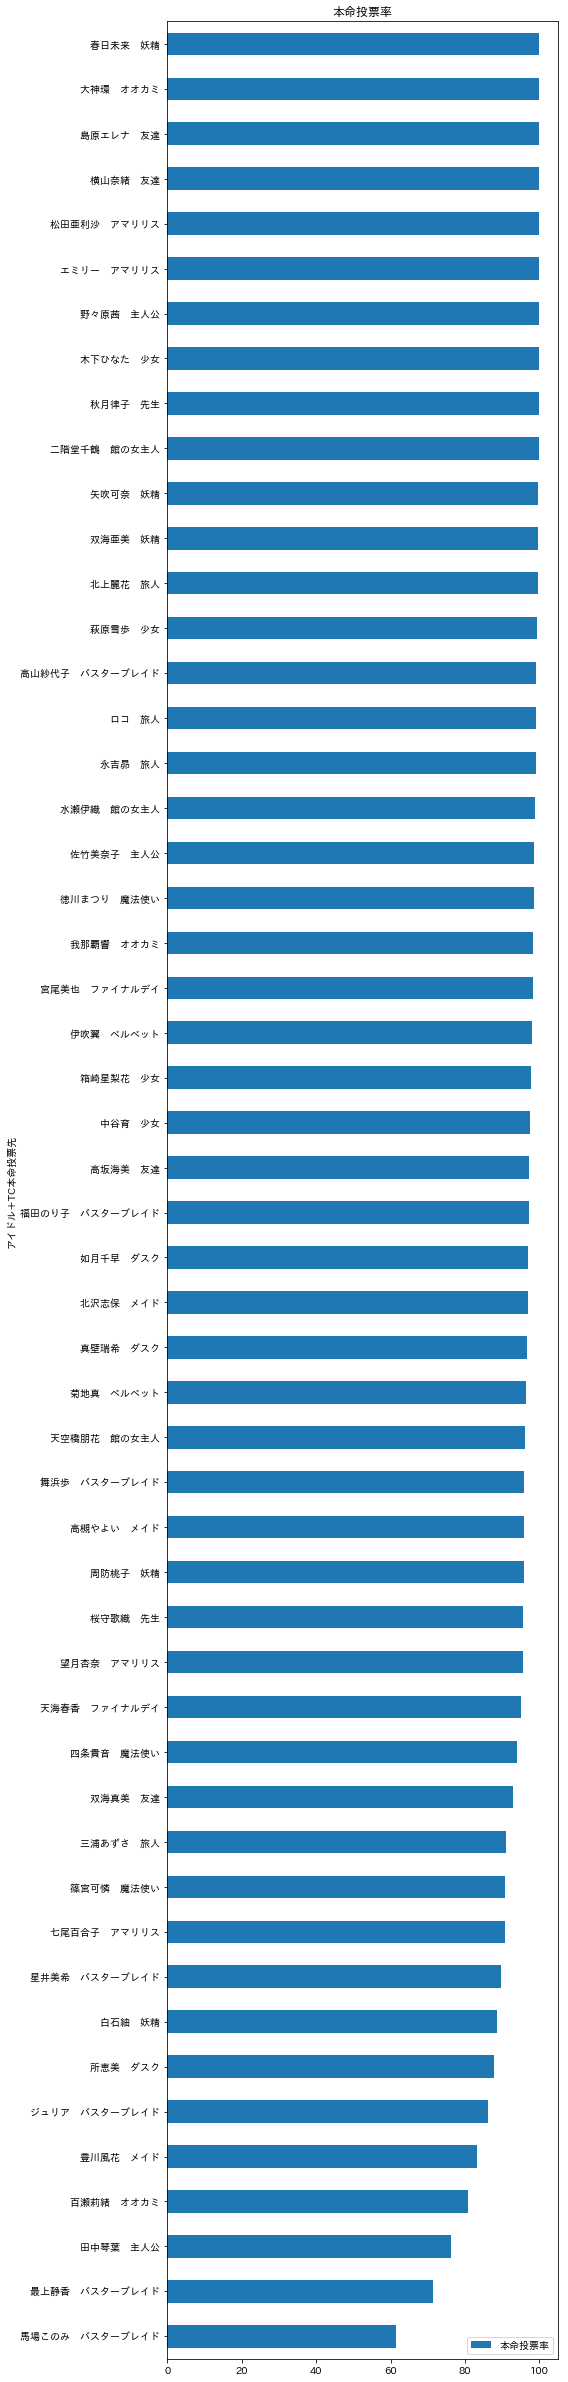

In [163]:
max_votes_role_idol = max_votes_role_idol.sort_values(ascending=True,by='本命投票率')
max_votes_role_idol.plot(kind='barh', x='アイドル＋TC本命投票先', y='本命投票率',figsize=(7,43),title='本命投票率')

### あだ花投票数：本命役以外に投票した数をアイドルごとにランキング。

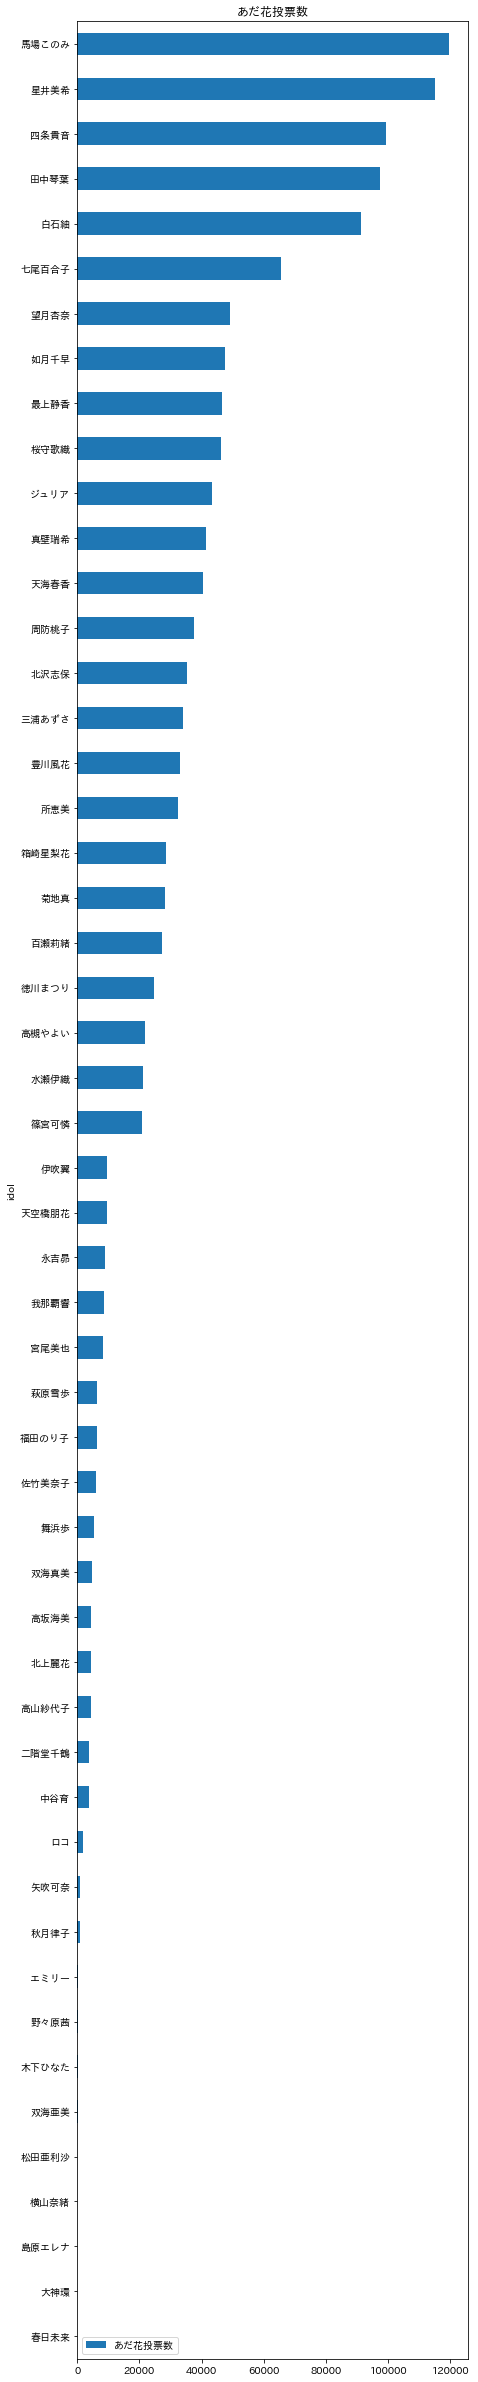

In [164]:
max_votes_role_idol['あだ花投票数'] = max_votes_role_idol['sum'] - max_votes_role_idol['votes']
max_votes_role_idol = max_votes_role_idol.sort_values(ascending=True,by='あだ花投票数')
max_votes_role_idol.plot(kind='barh', x='idol', y='あだ花投票数',figsize=(7,43),title='あだ花投票数')

### 人気役：本命役として票を投じた陣営の数＝役を争ったアイドルの人数

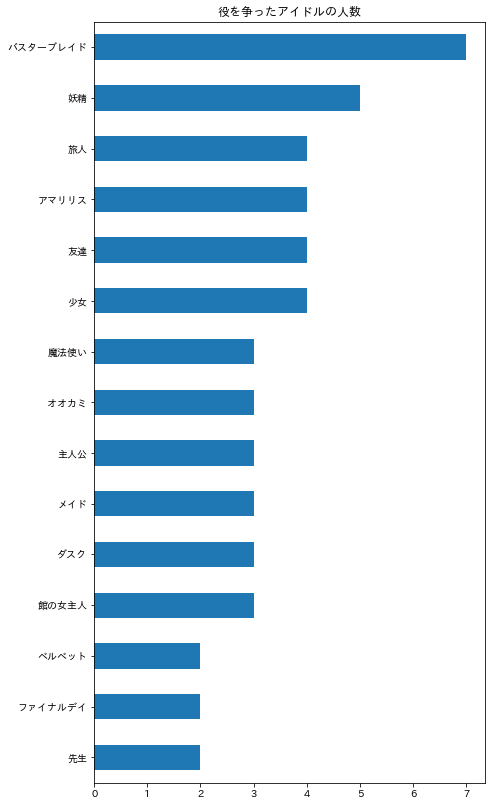

In [165]:
famous_role = max_votes_role_idol['role']
famous_role.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(7,14),title='役を争ったアイドルの人数')

### 最後に、アイドルごとの投票先の詳細をプロット

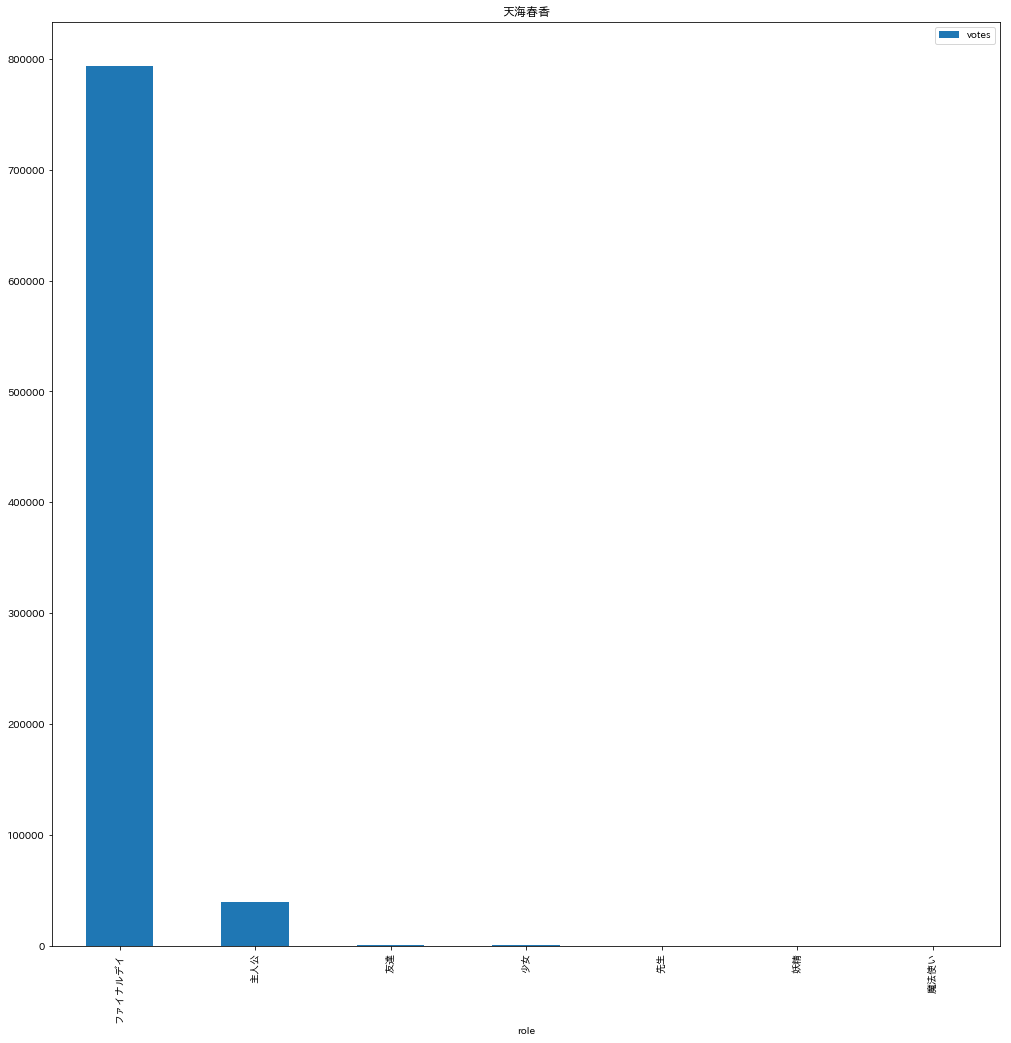

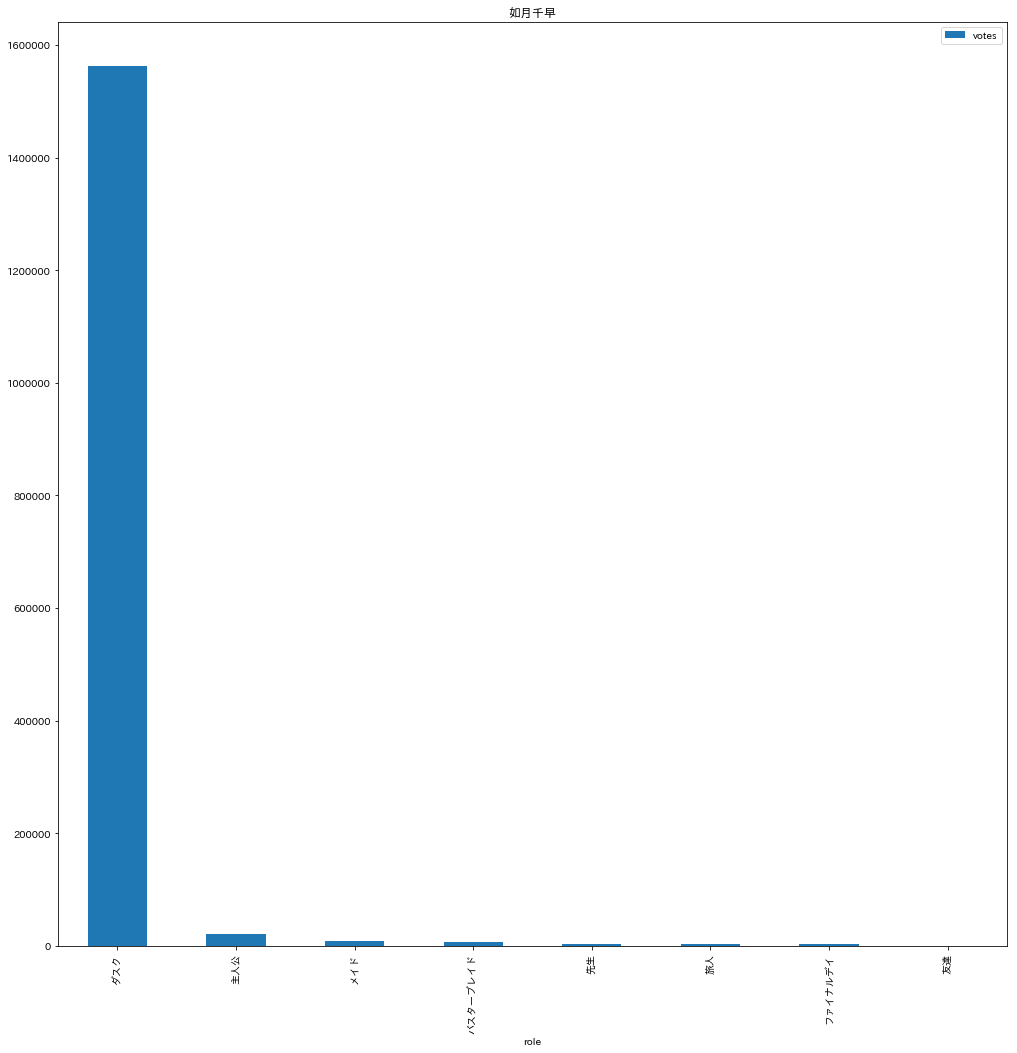

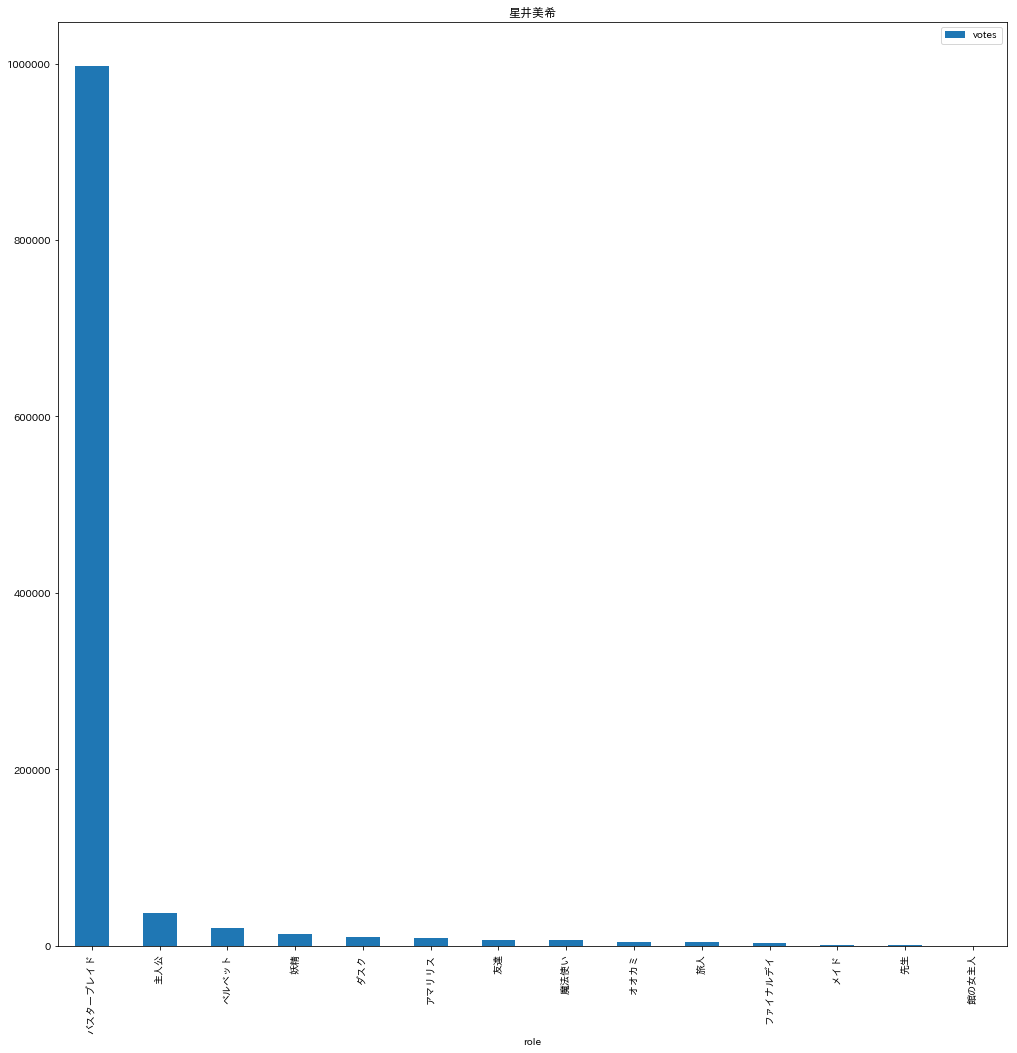

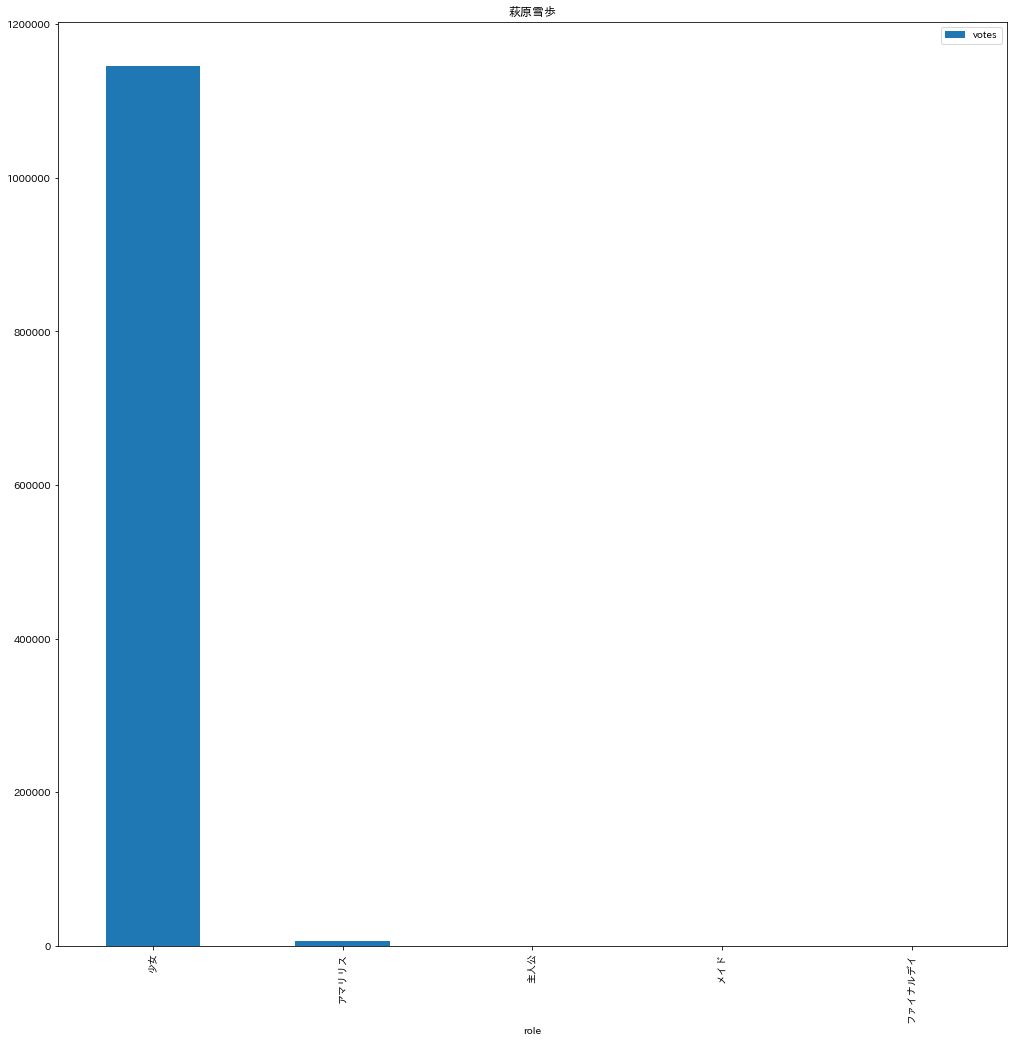

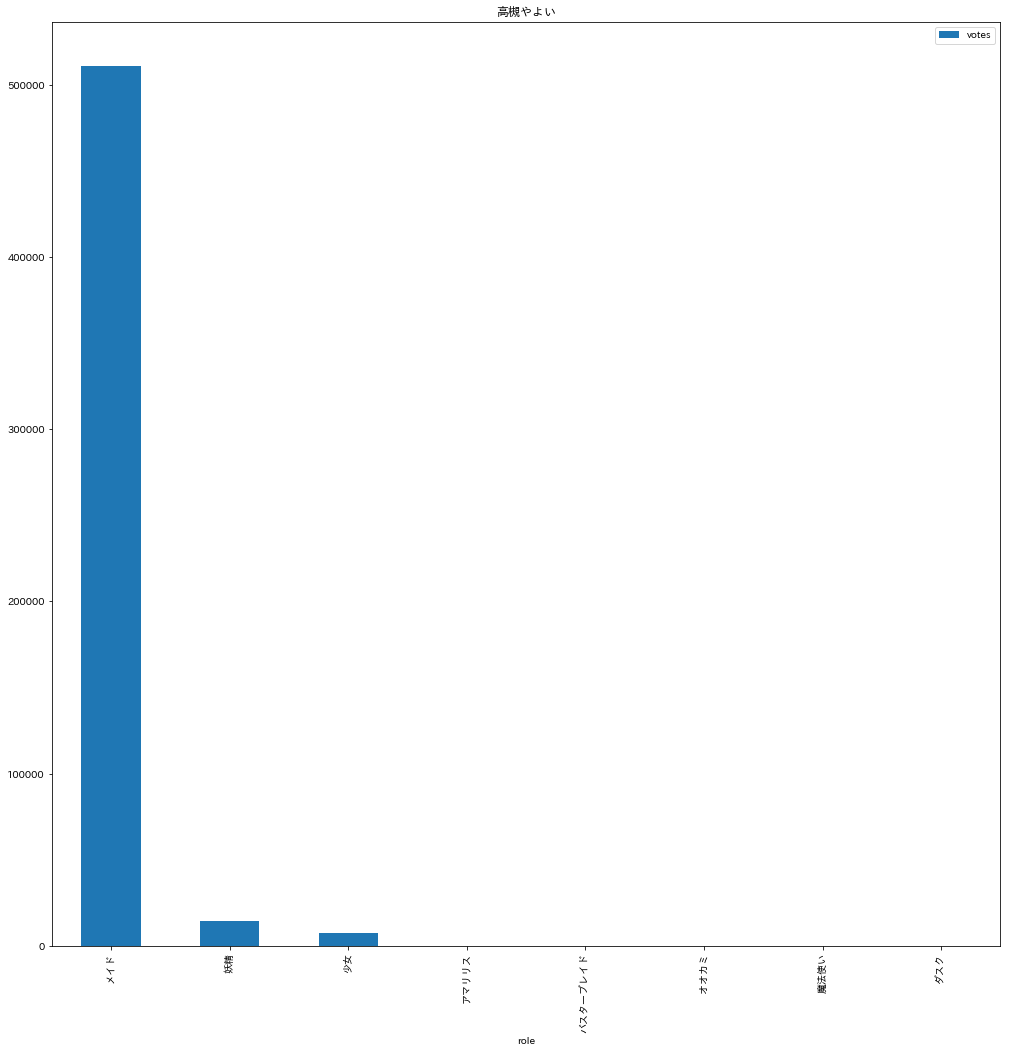

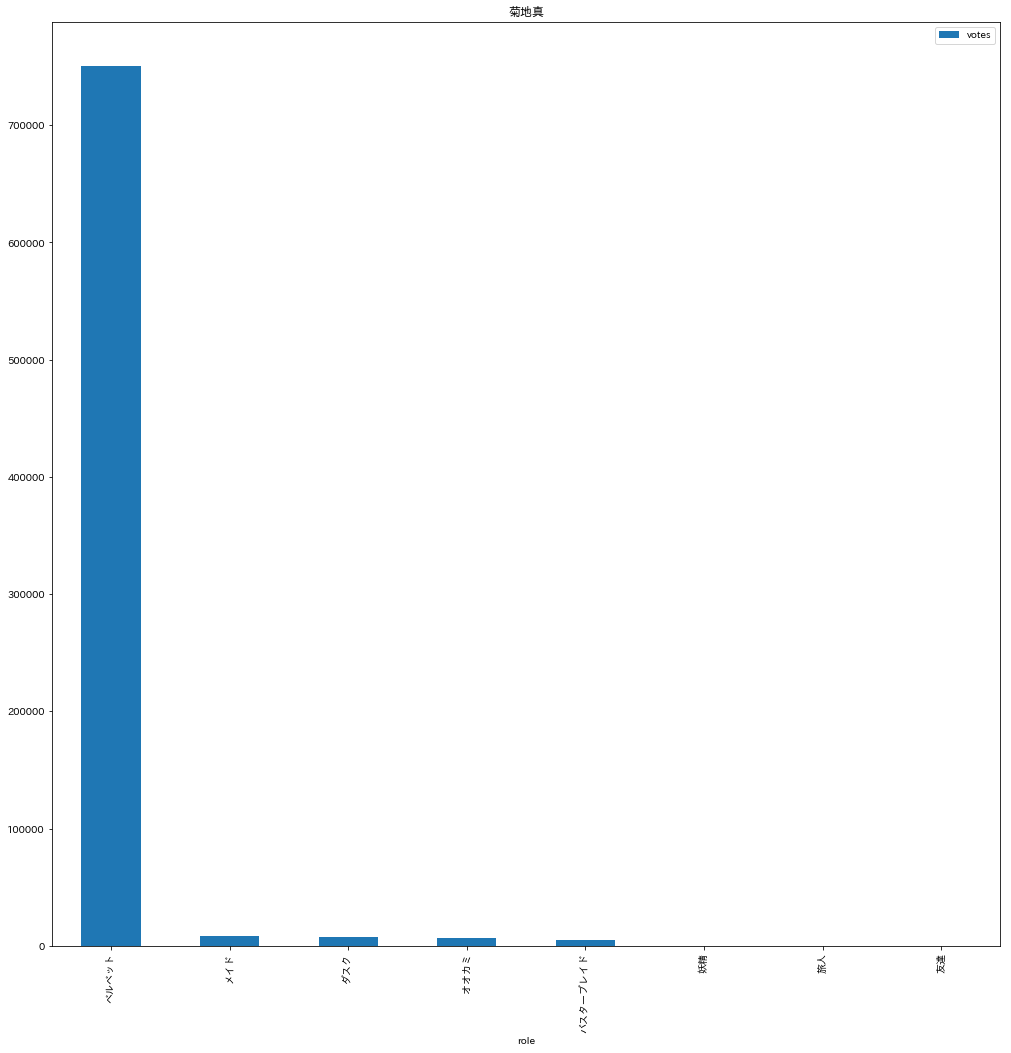

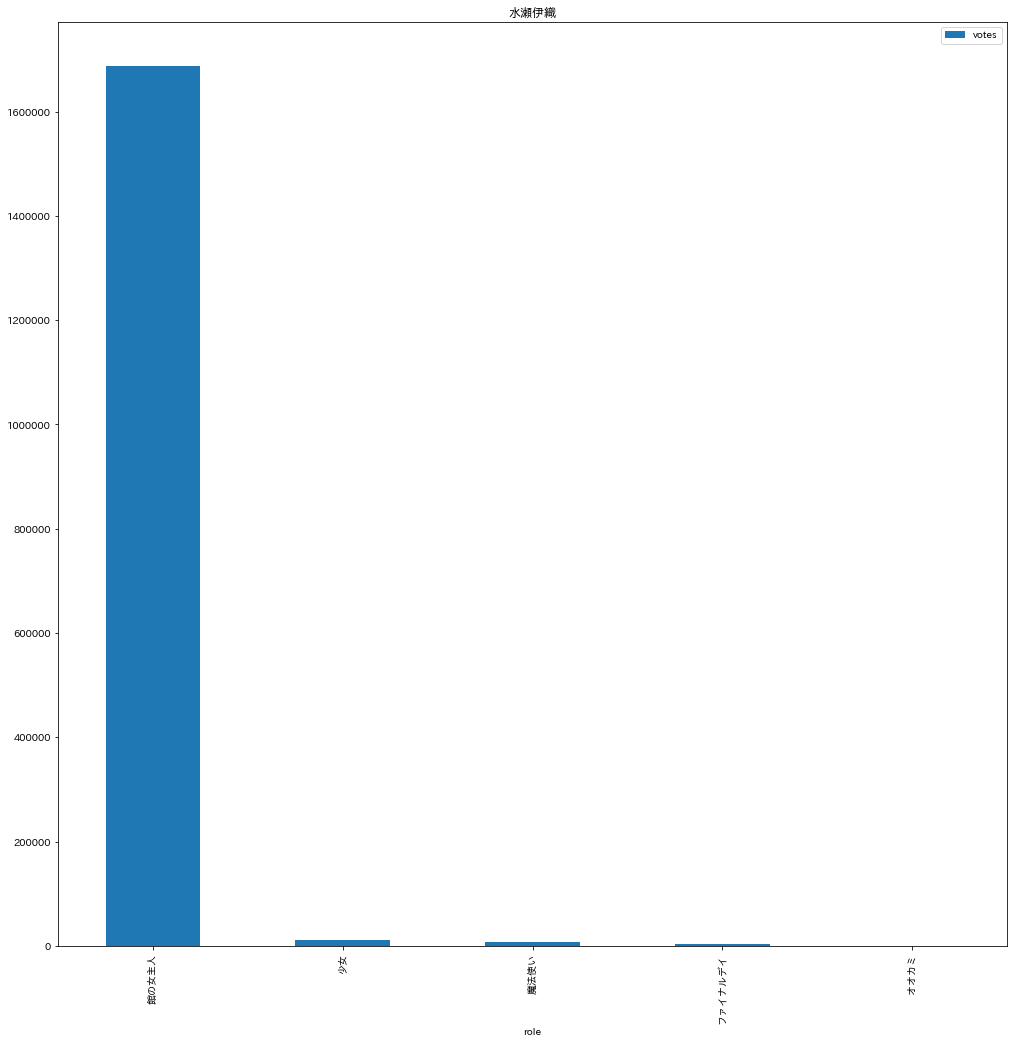

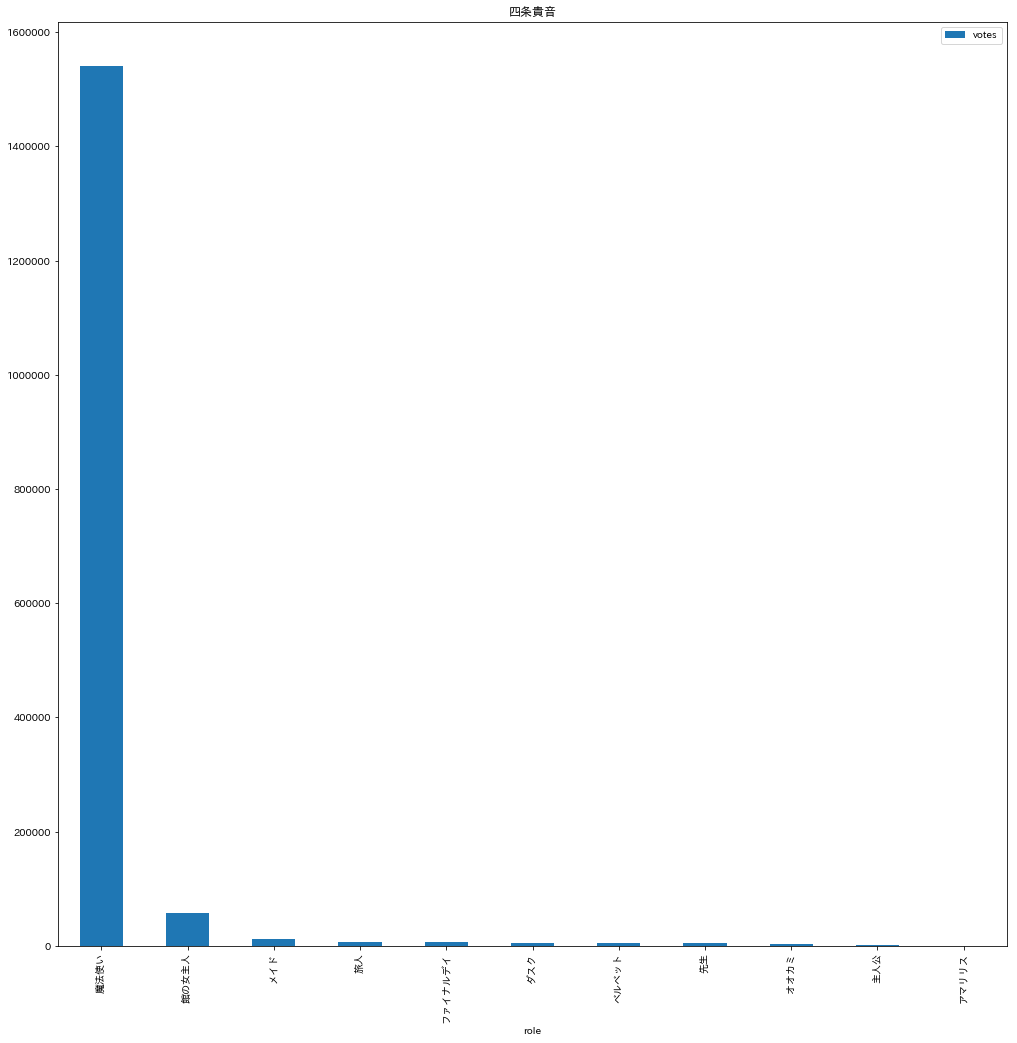

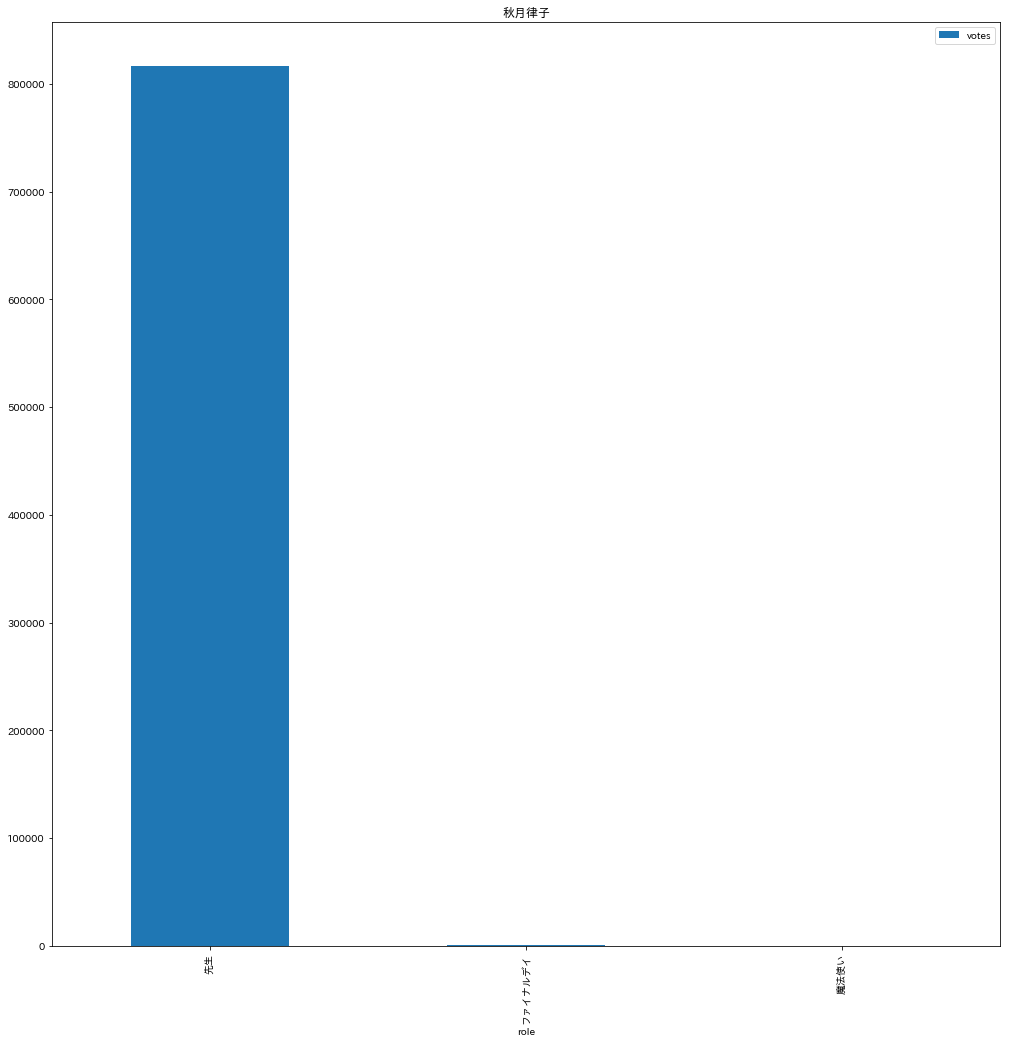

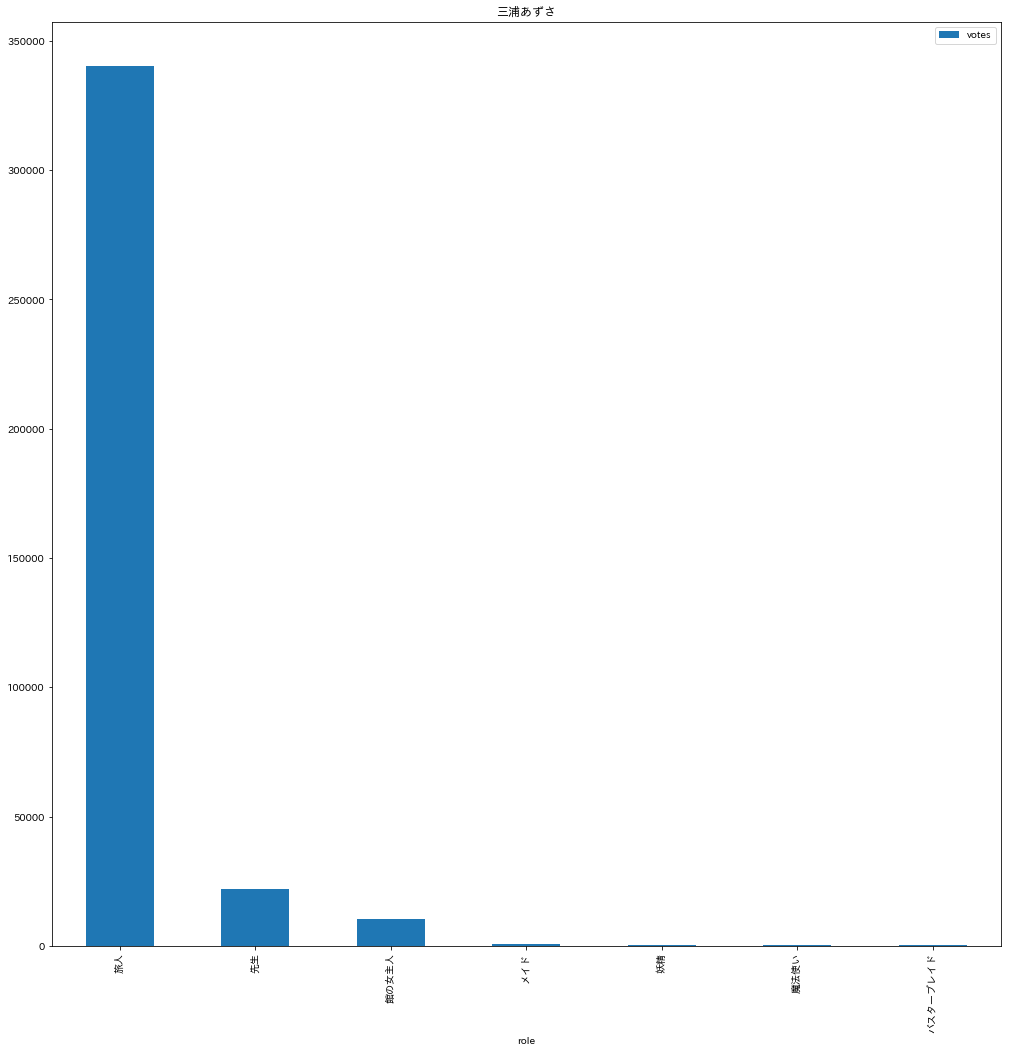

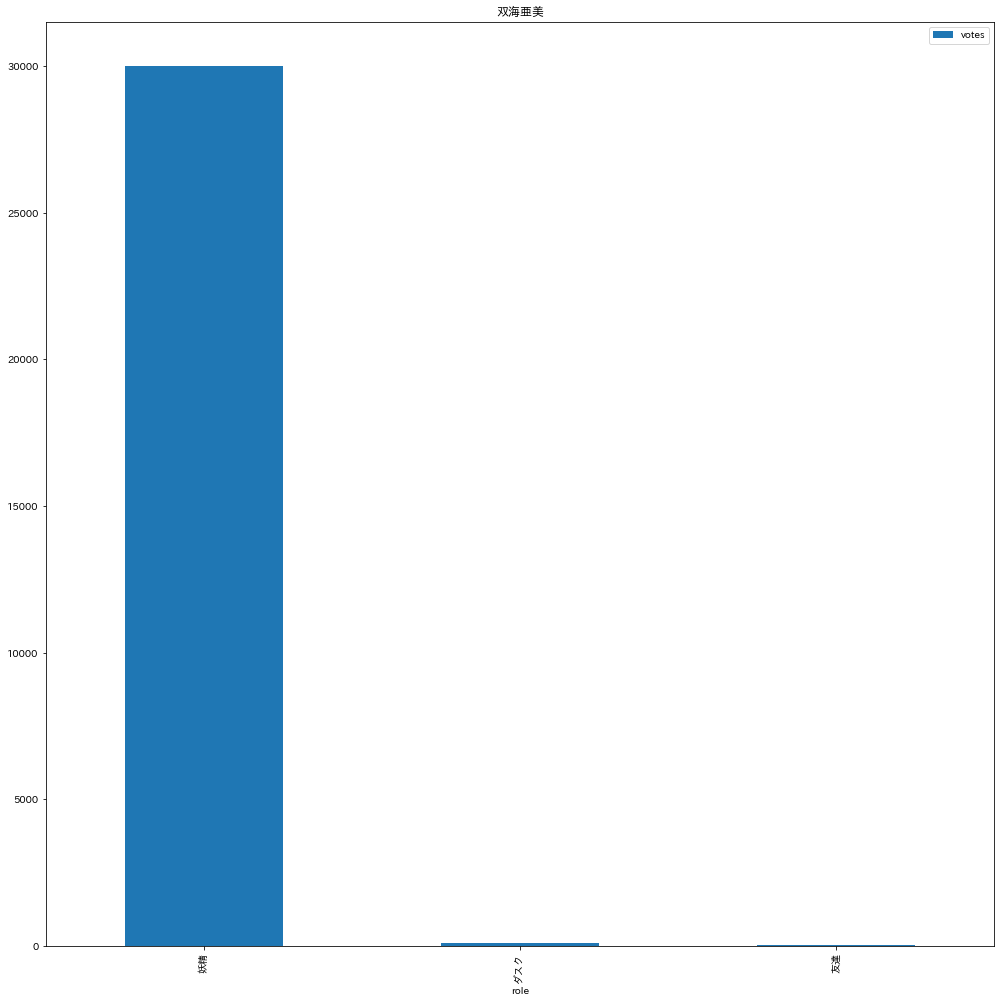

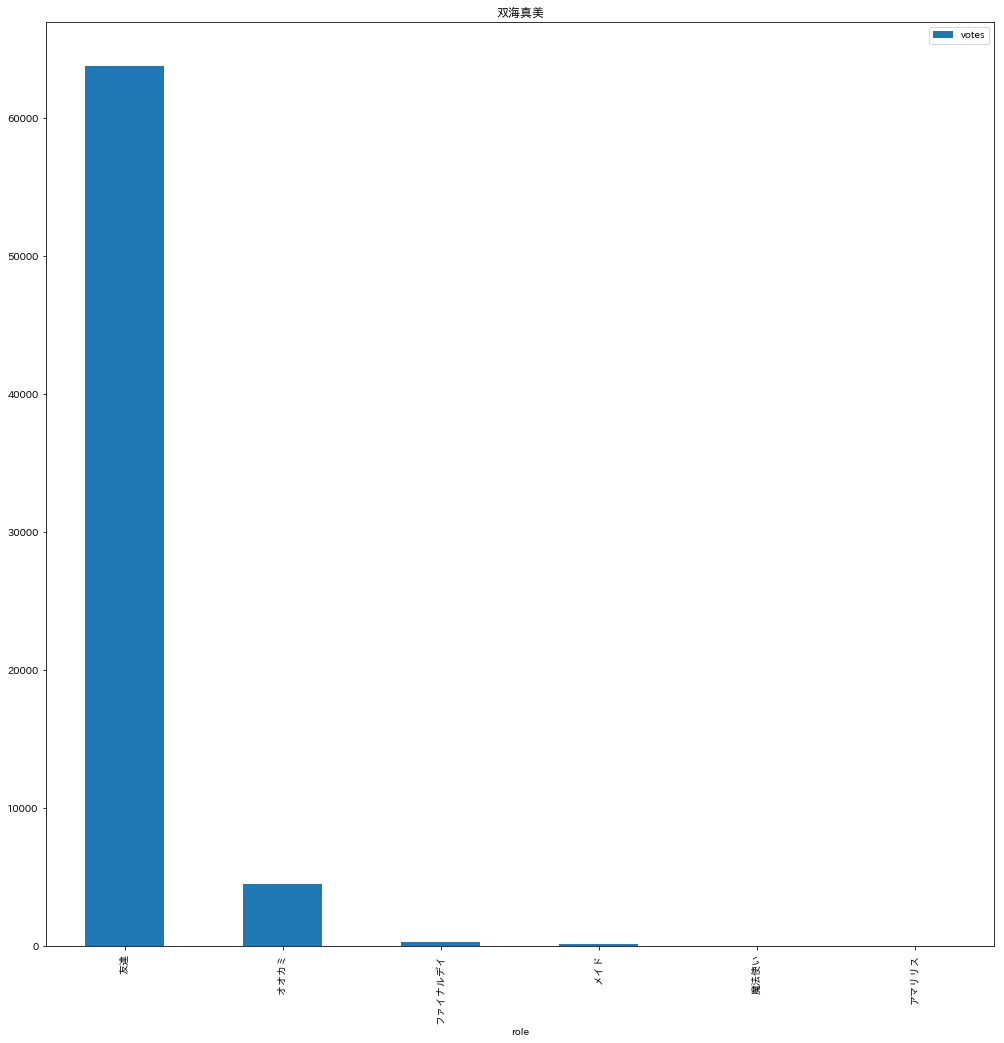

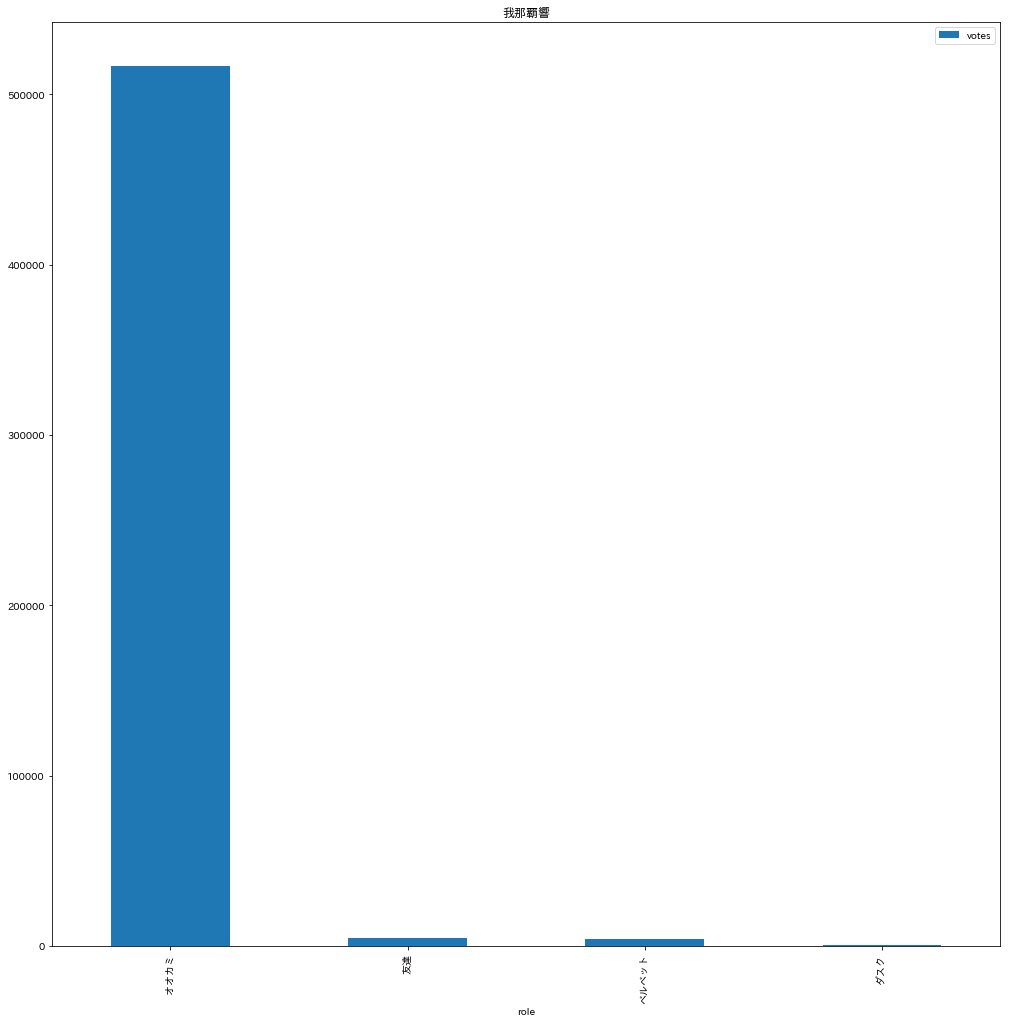

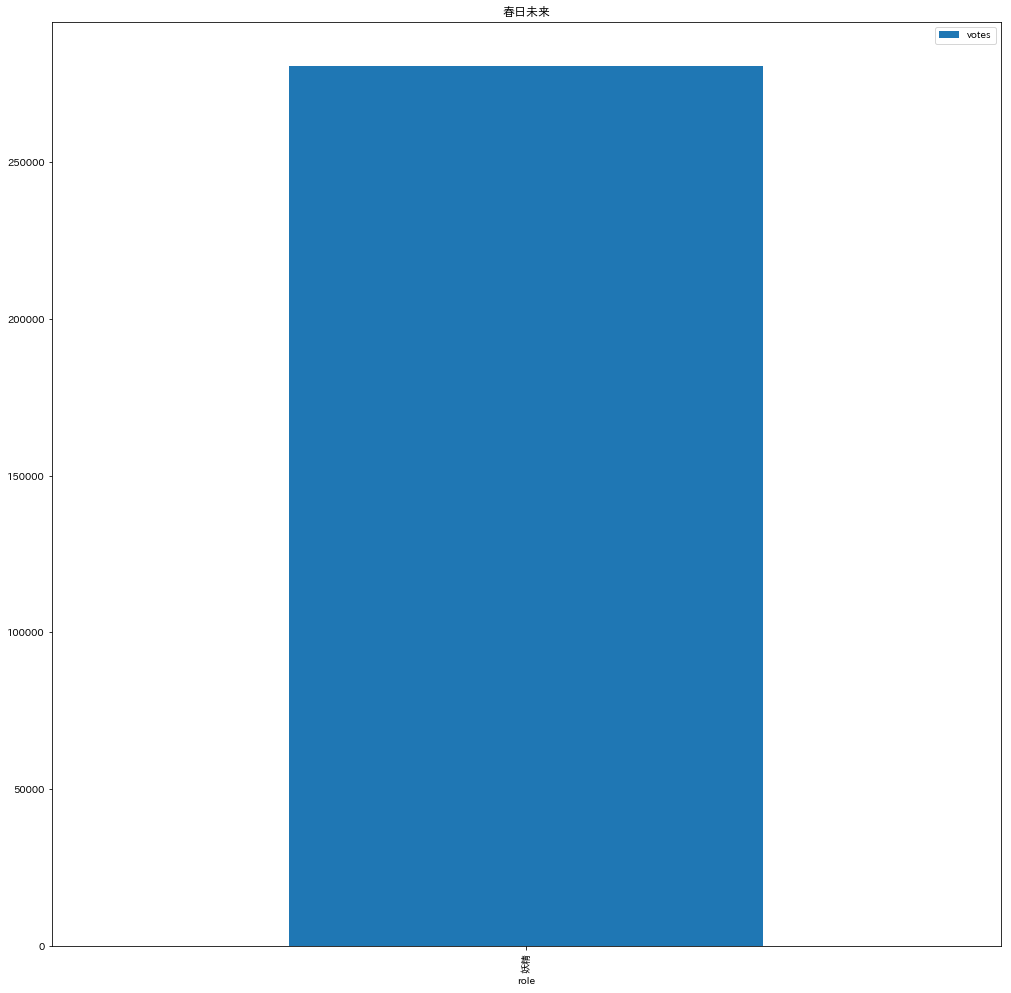

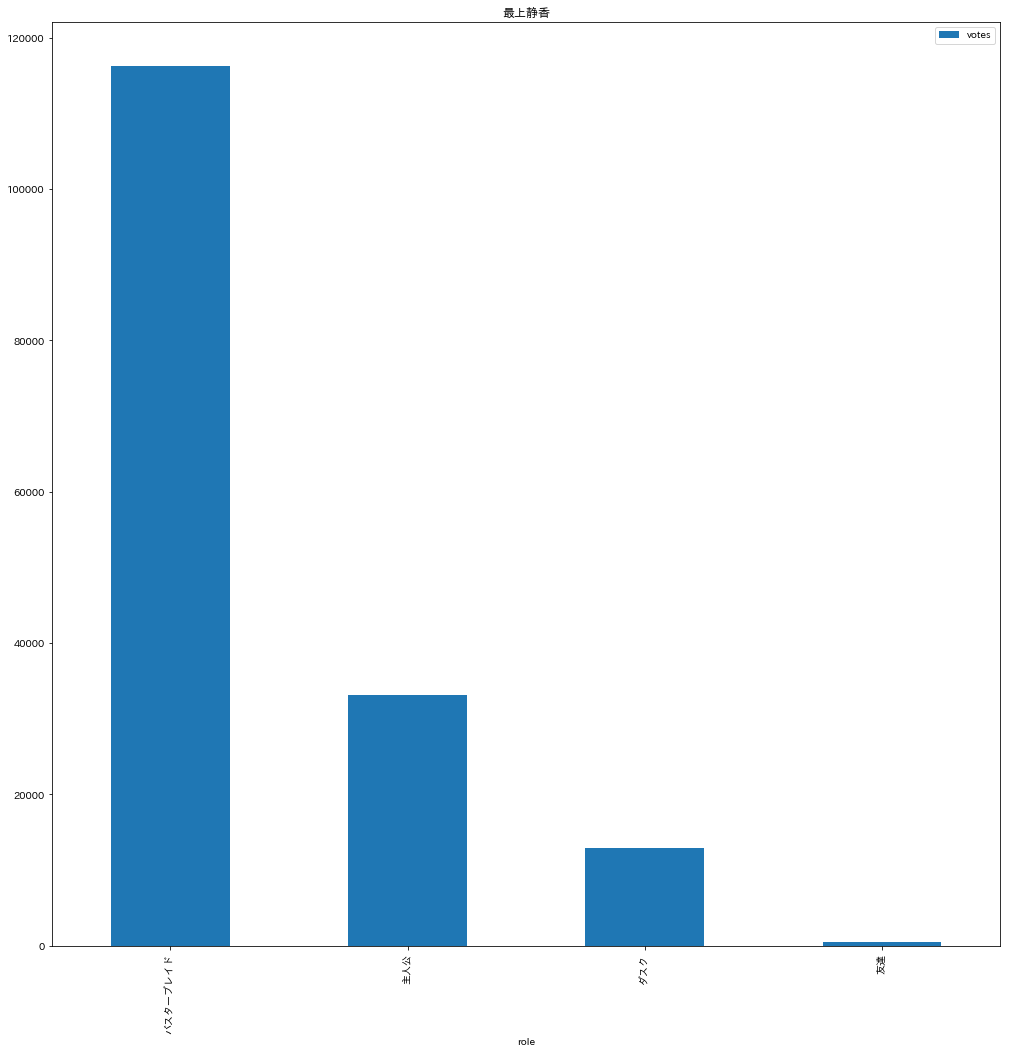

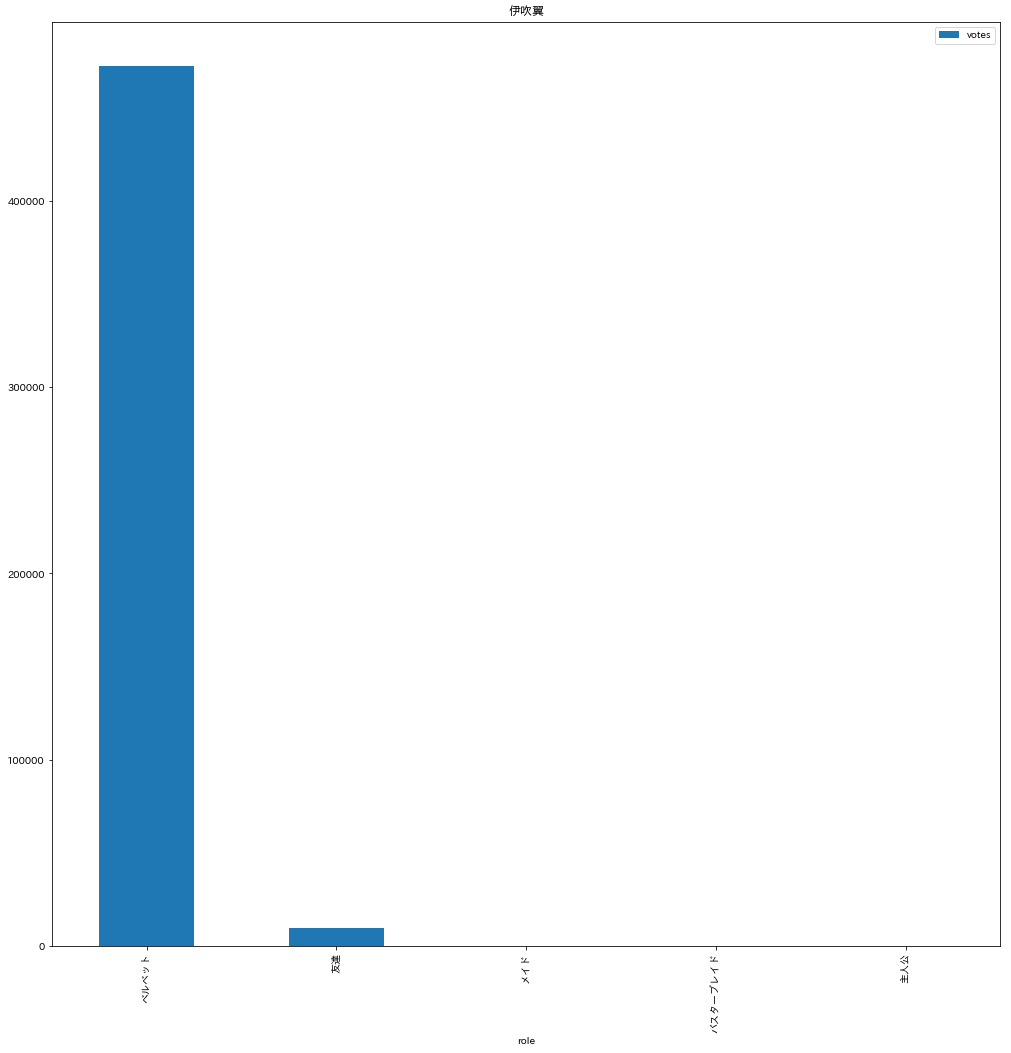

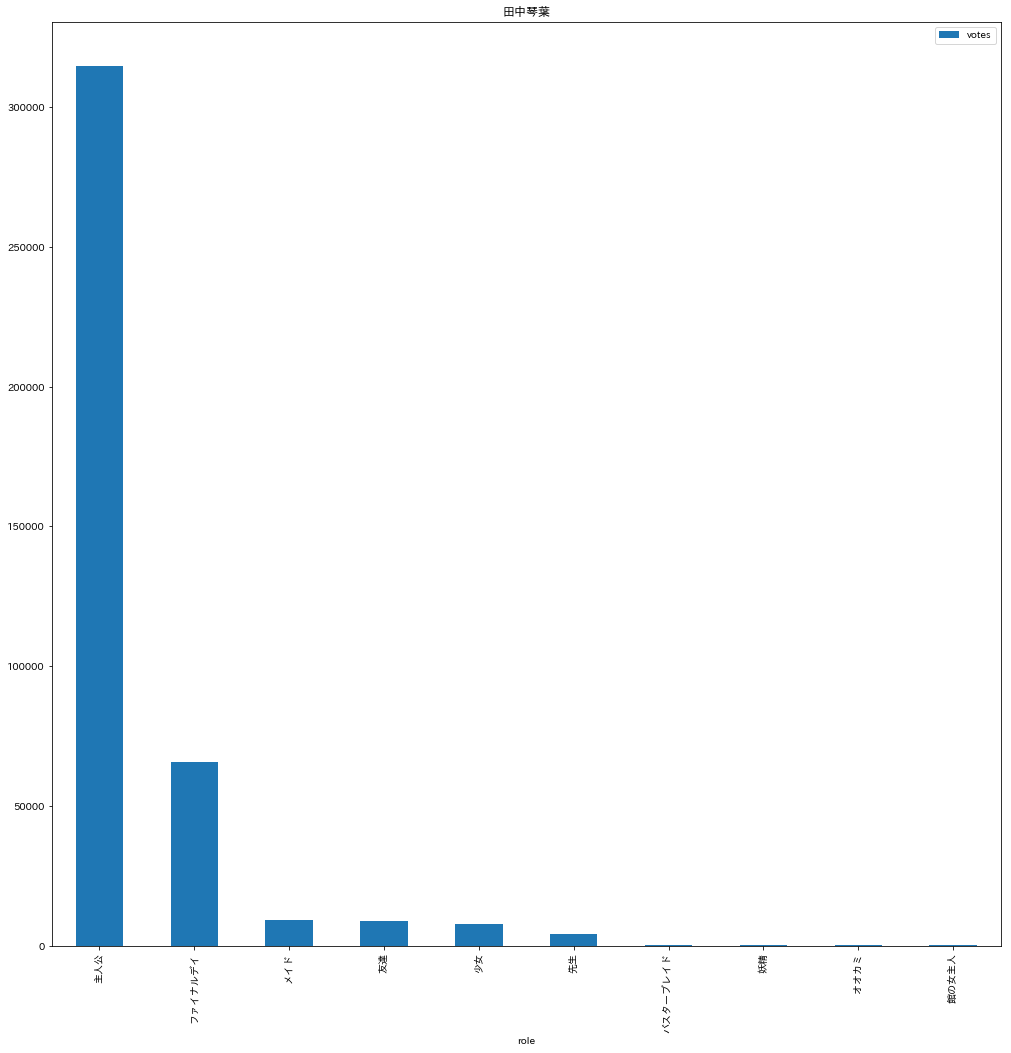

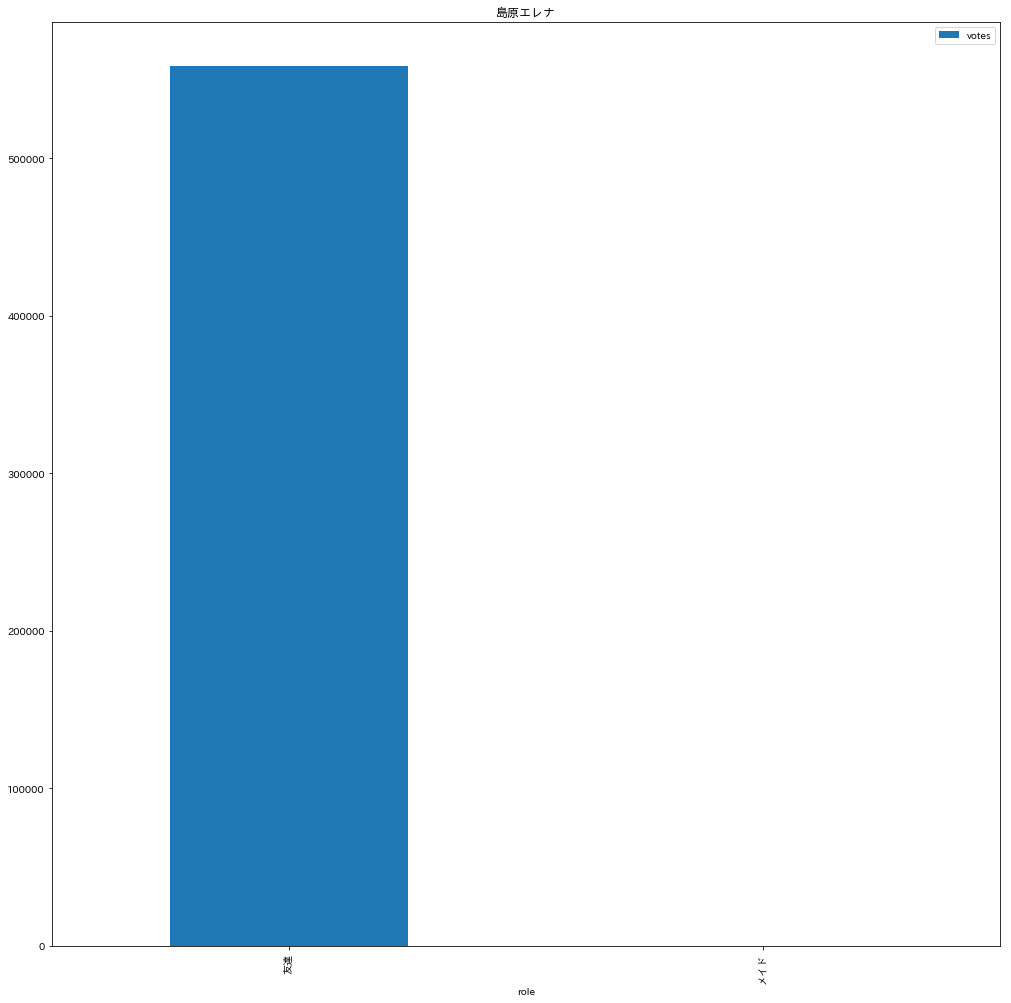

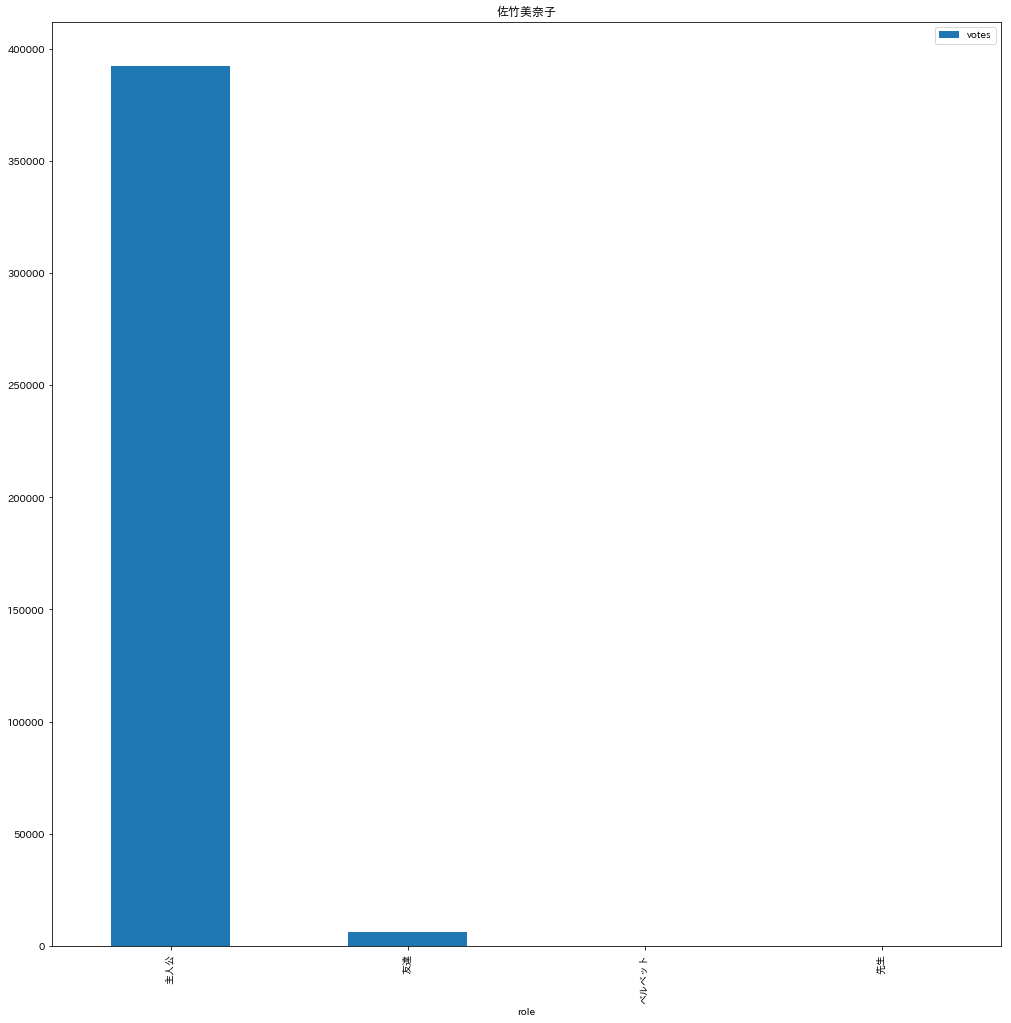

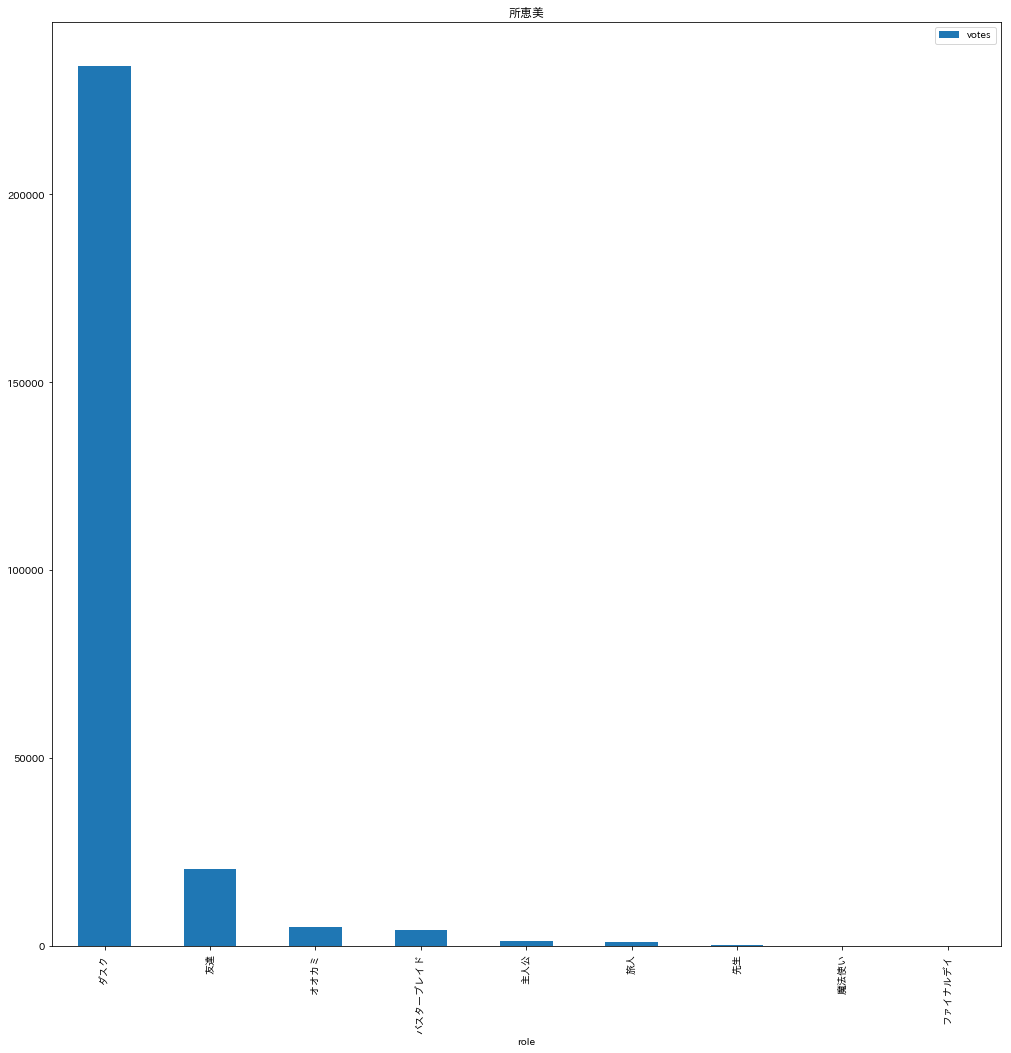

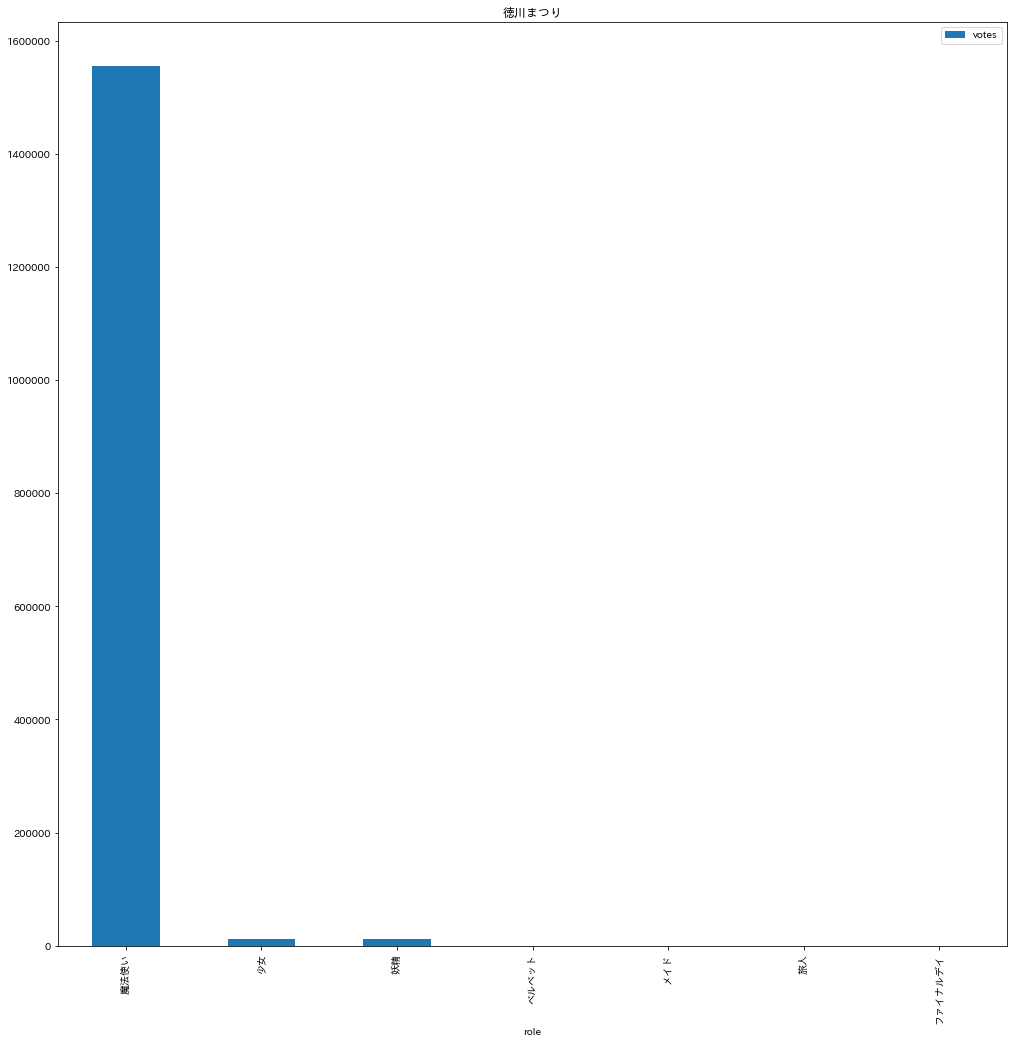

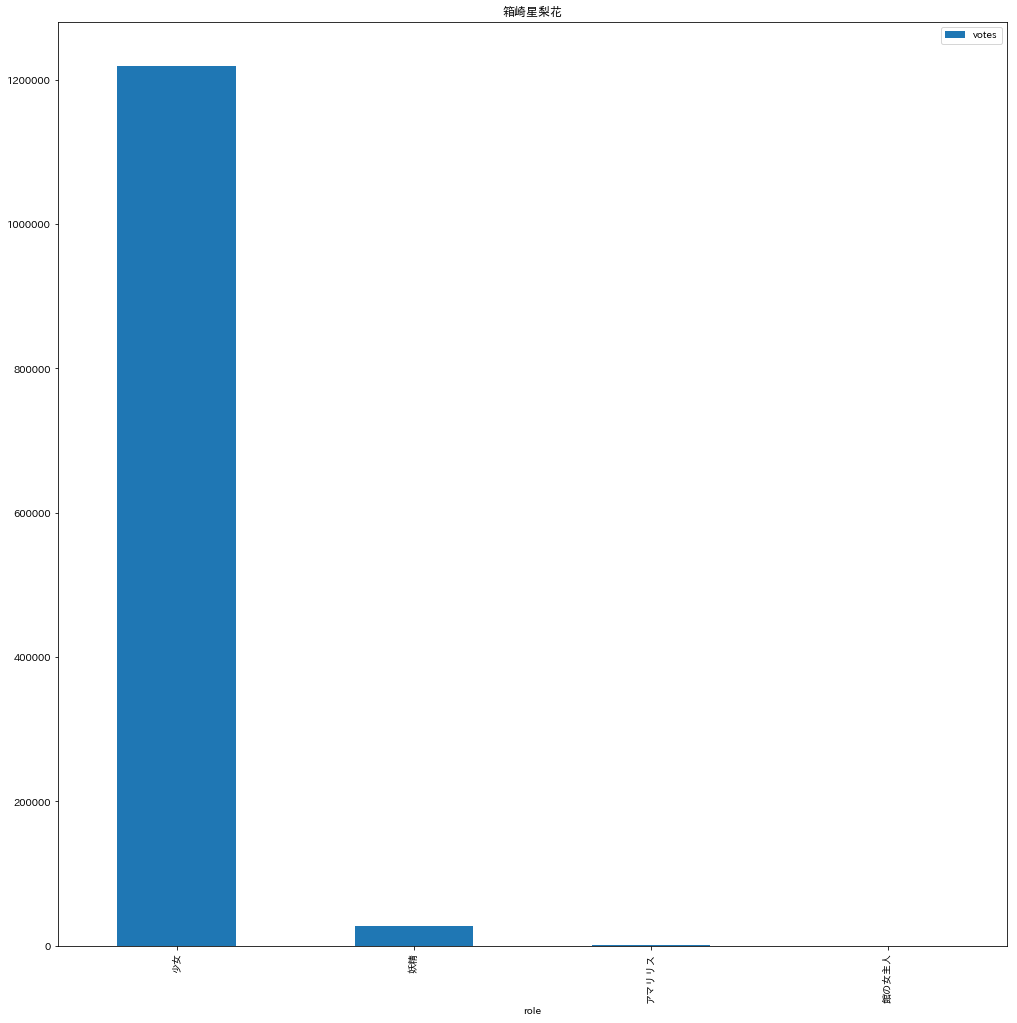

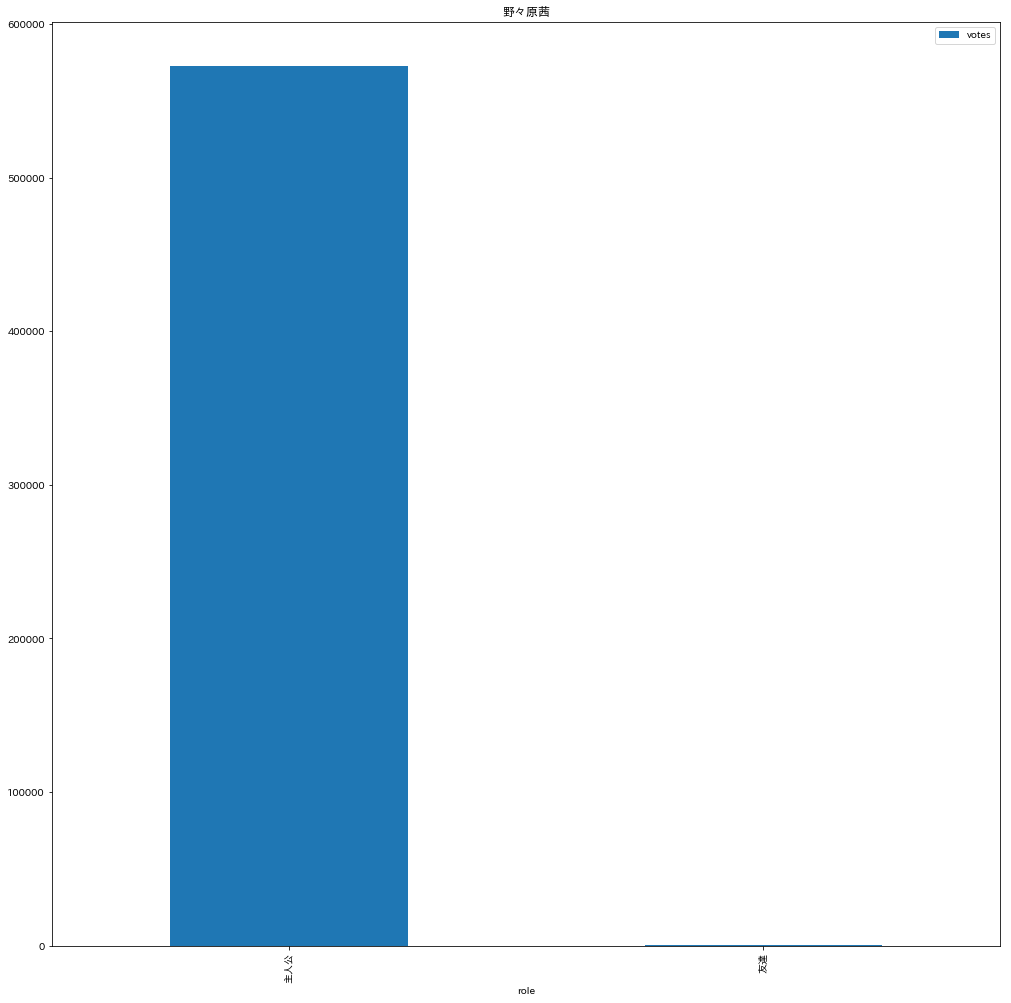

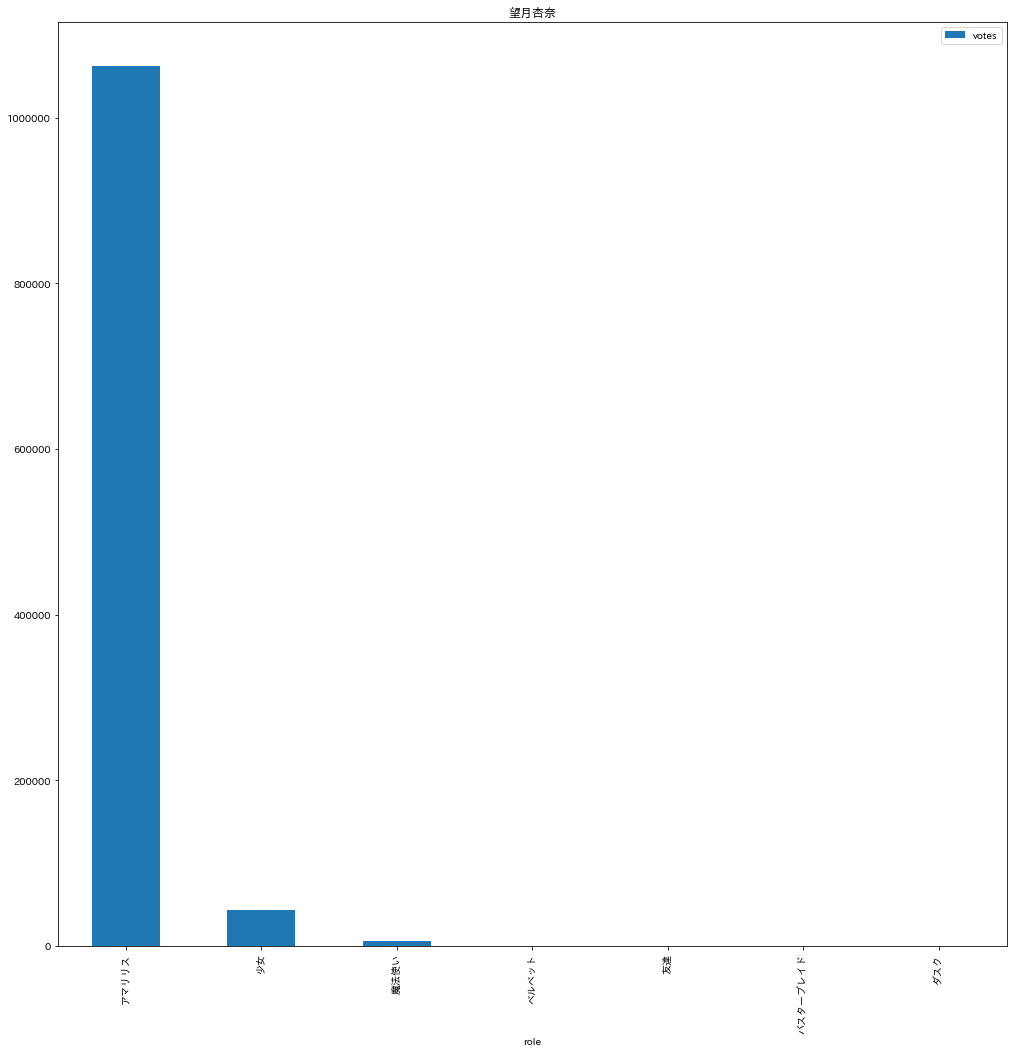

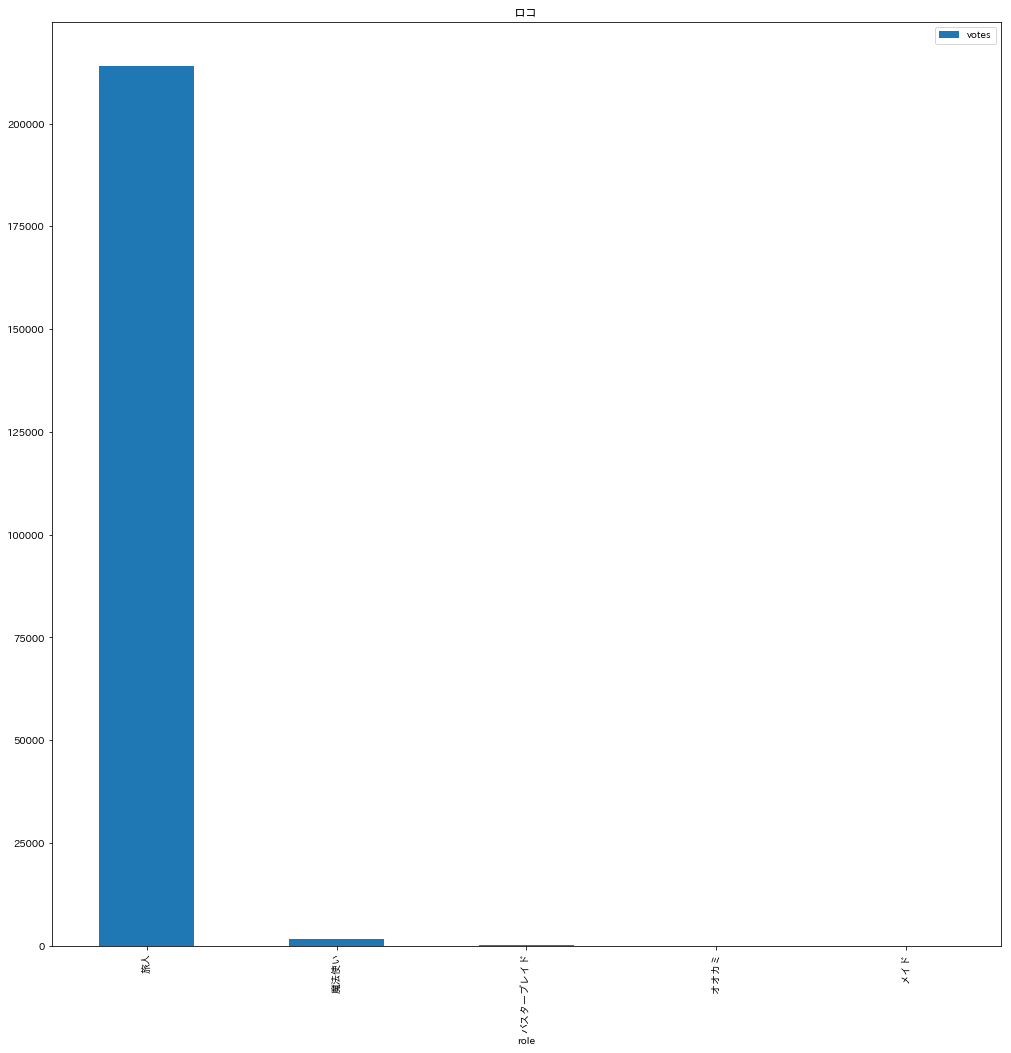

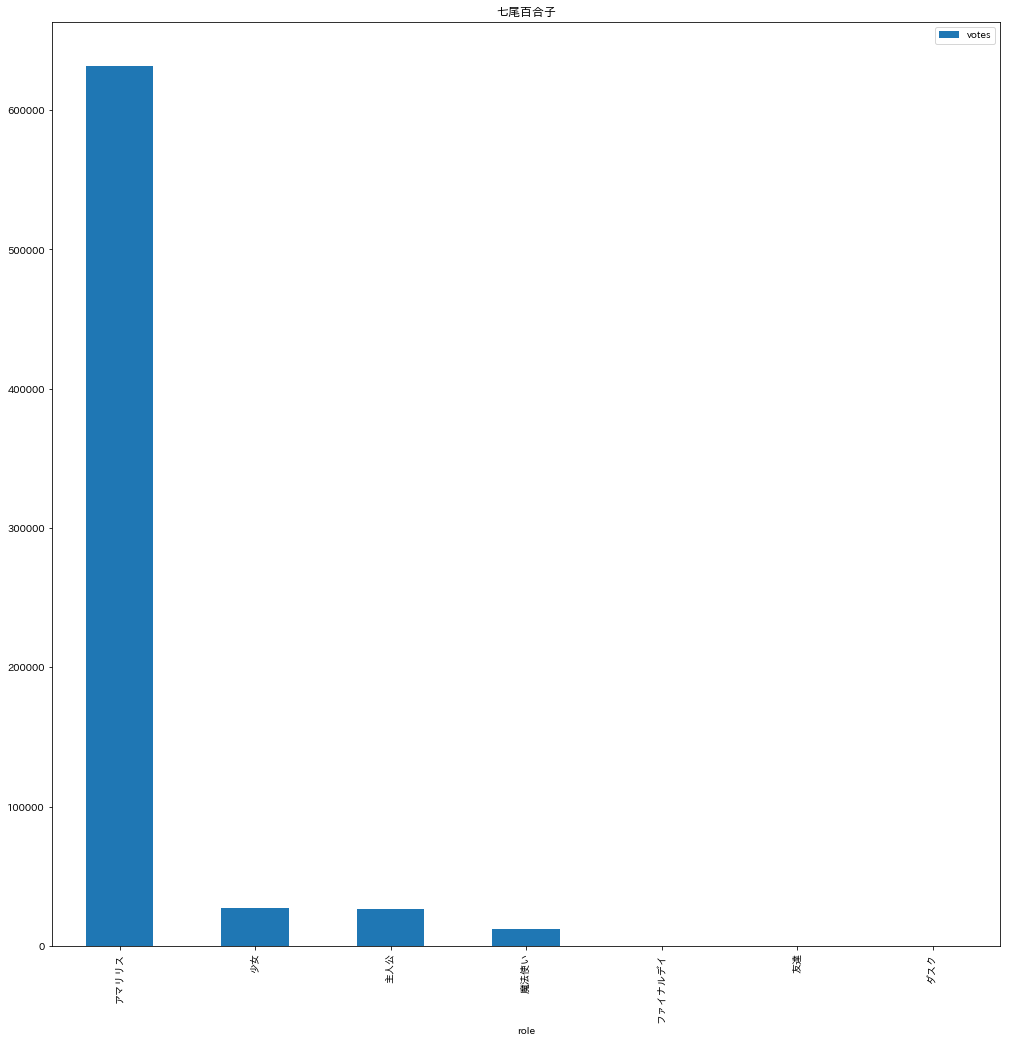

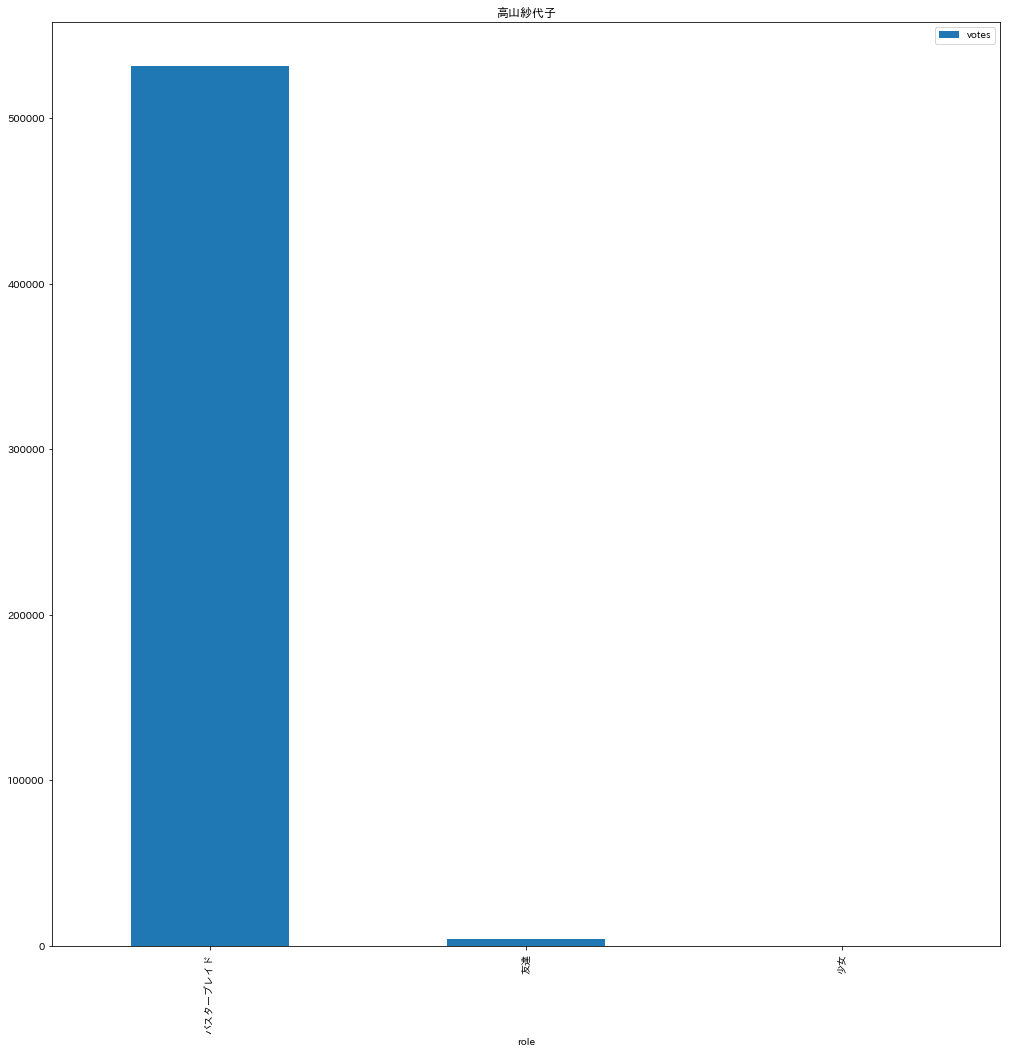

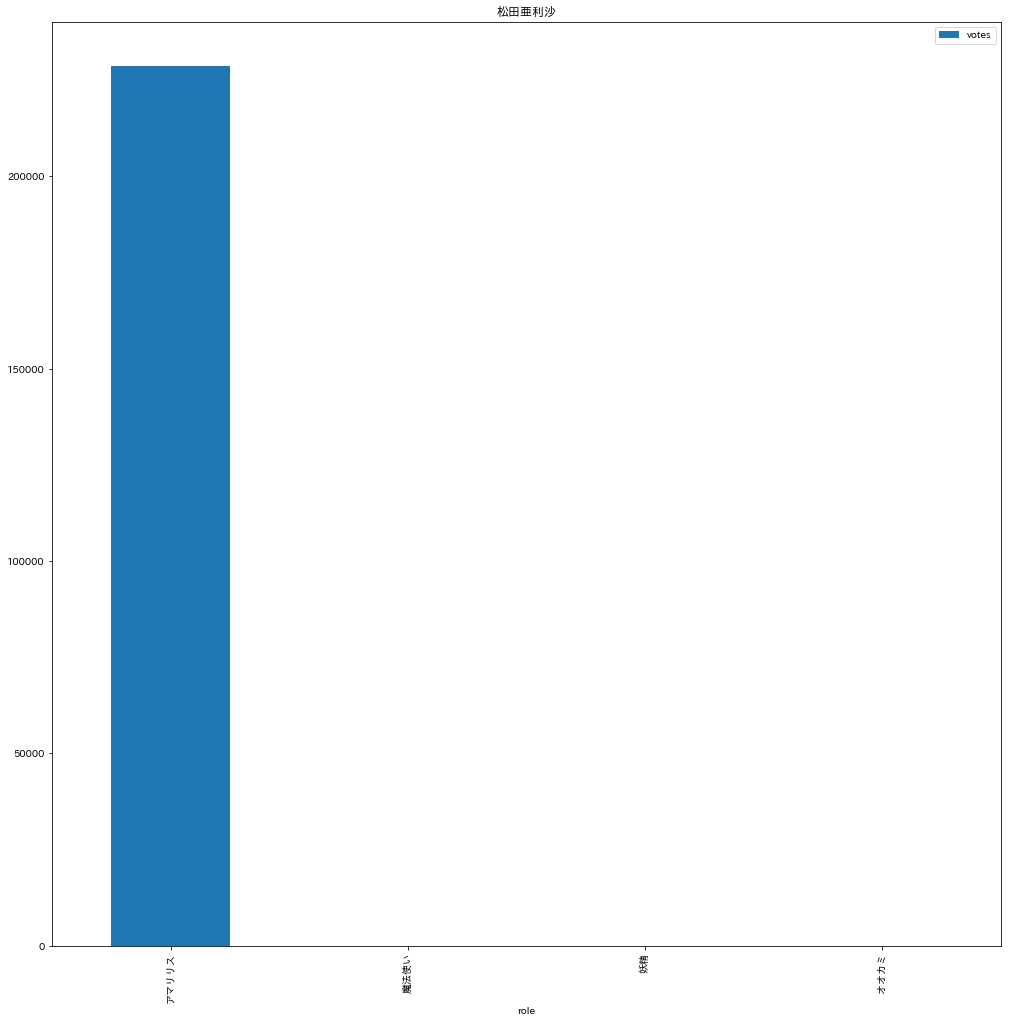

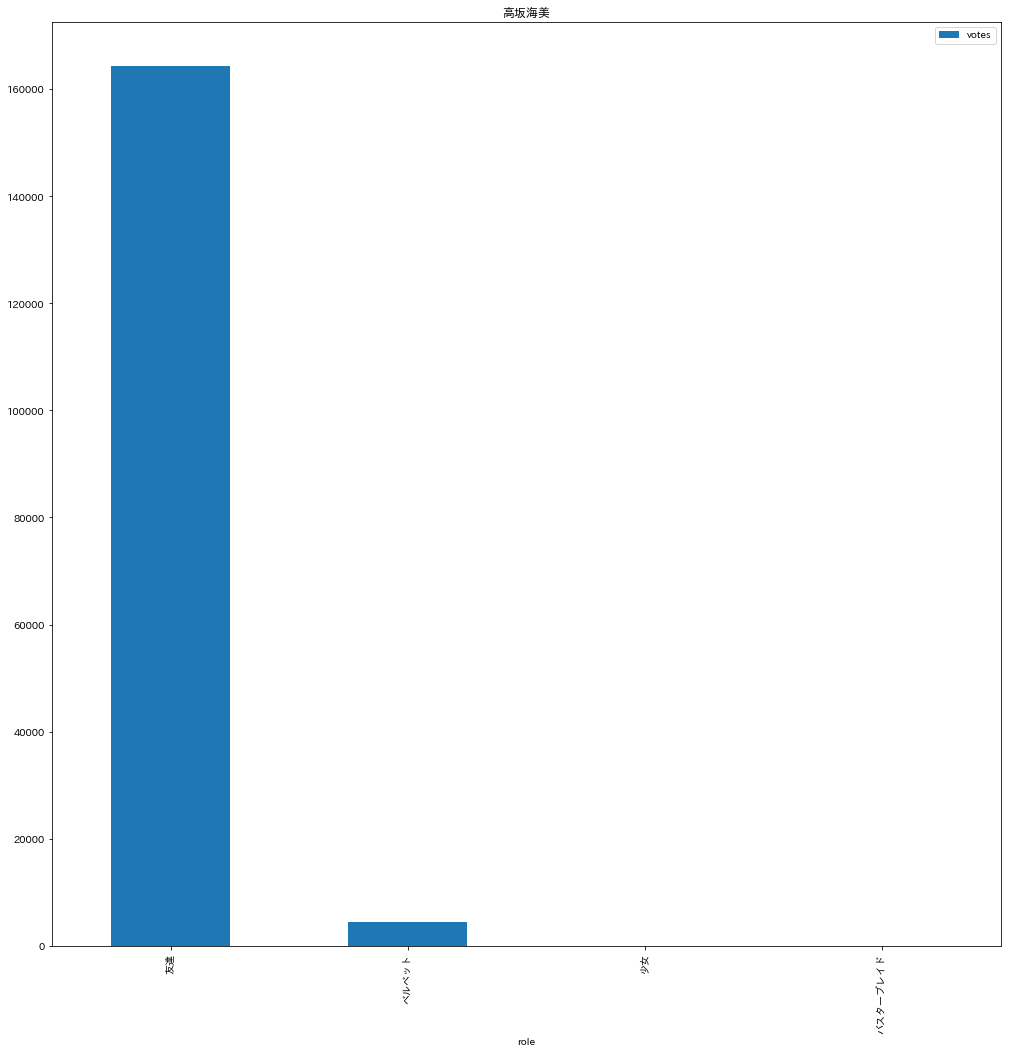

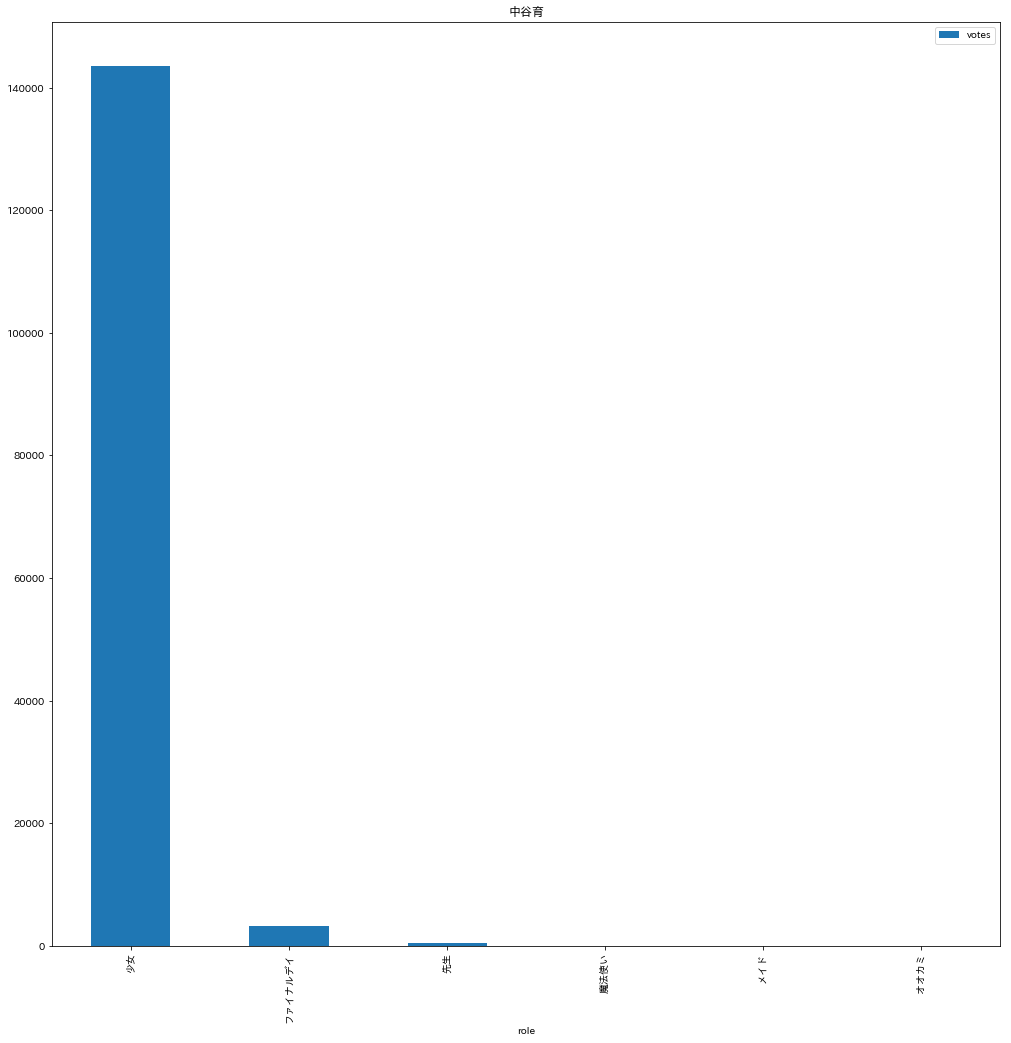

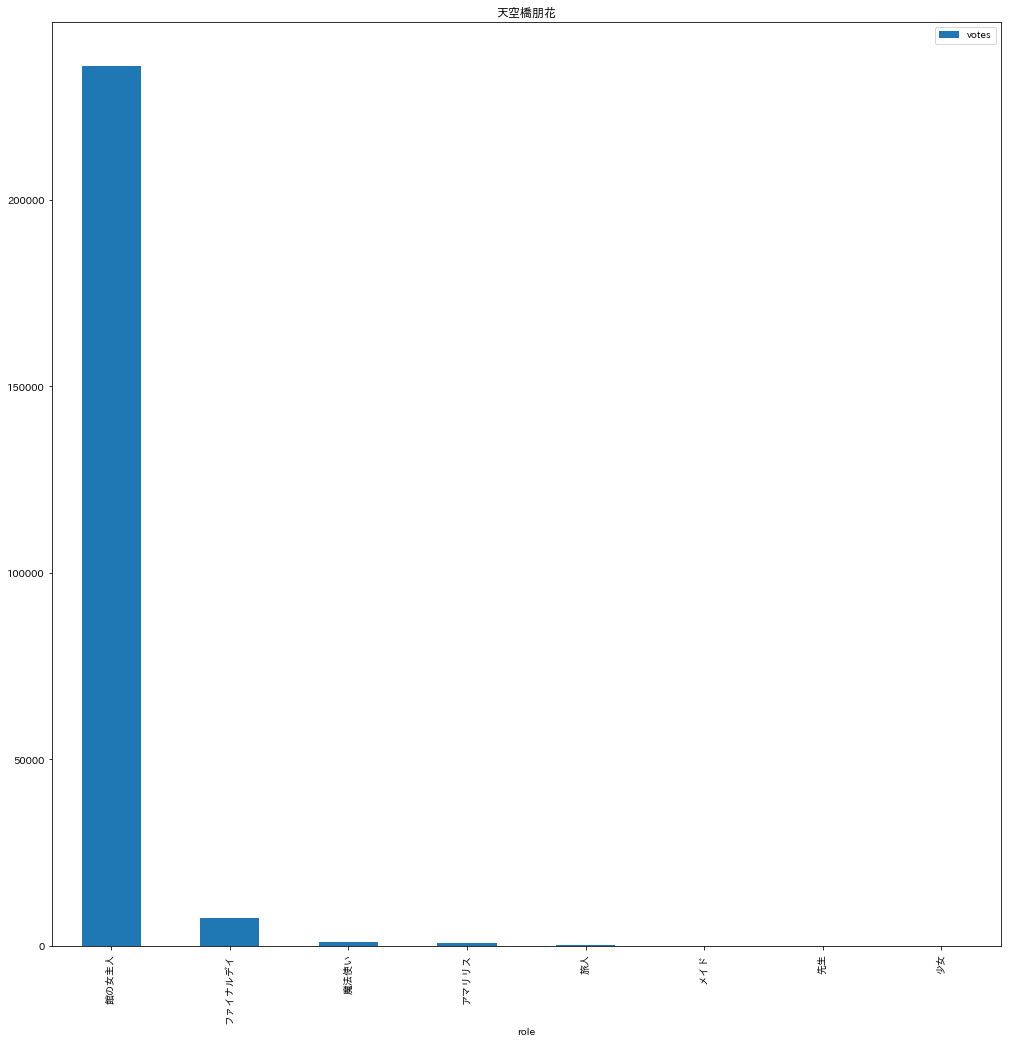

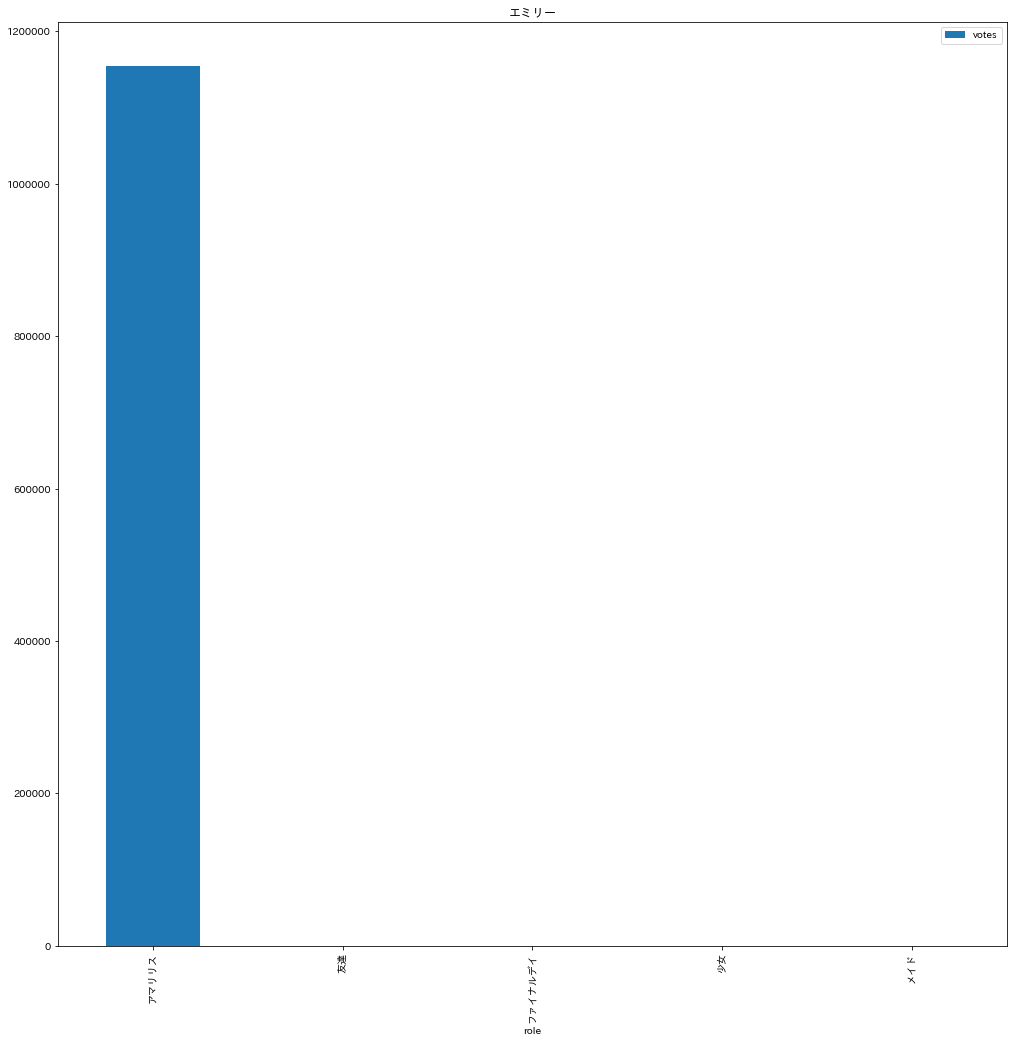

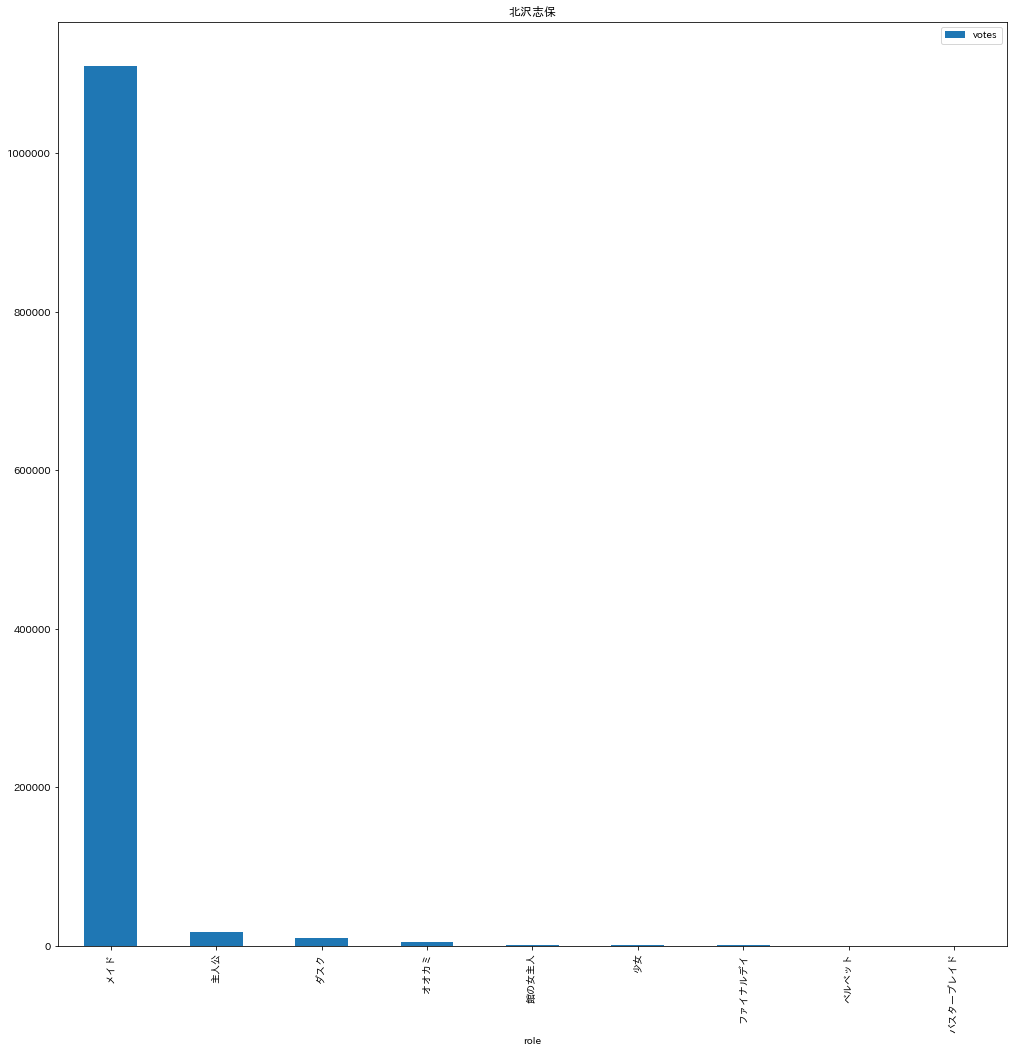

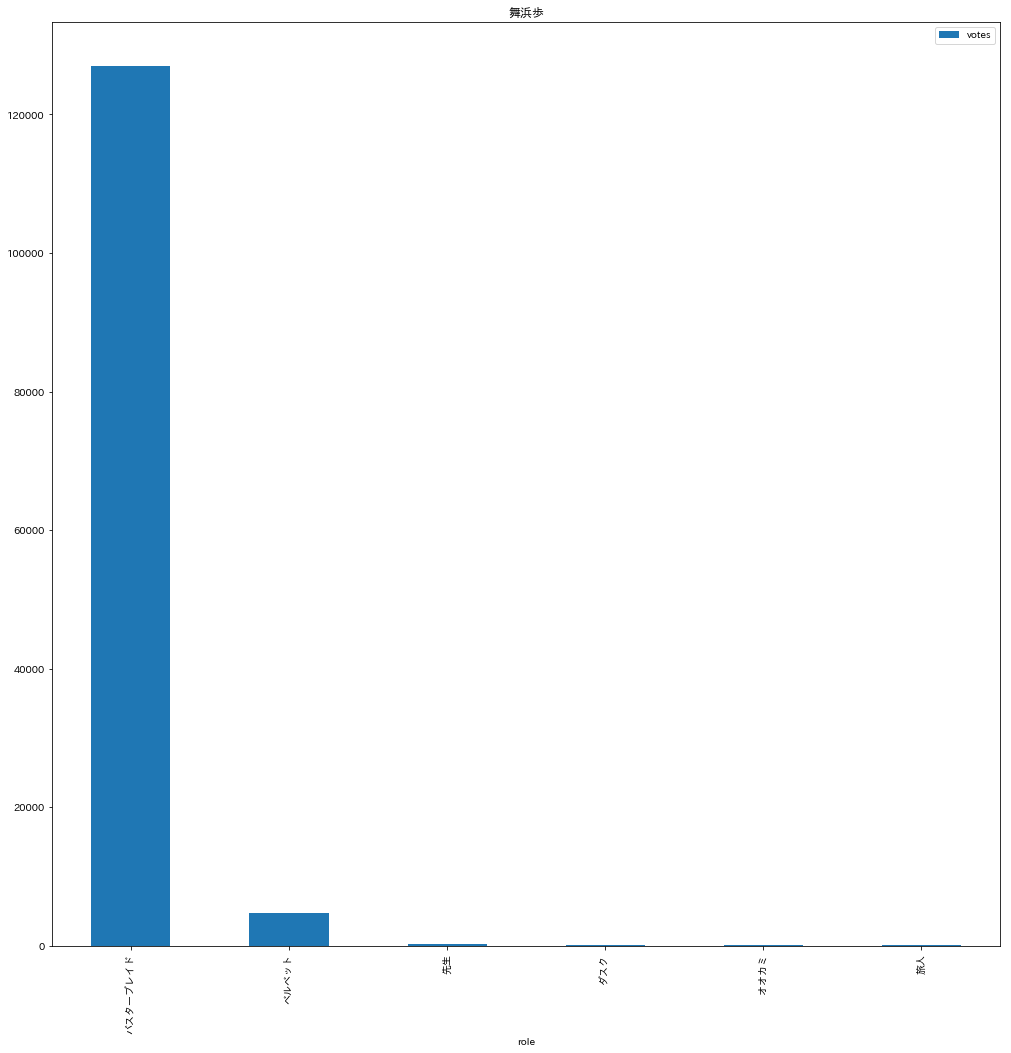

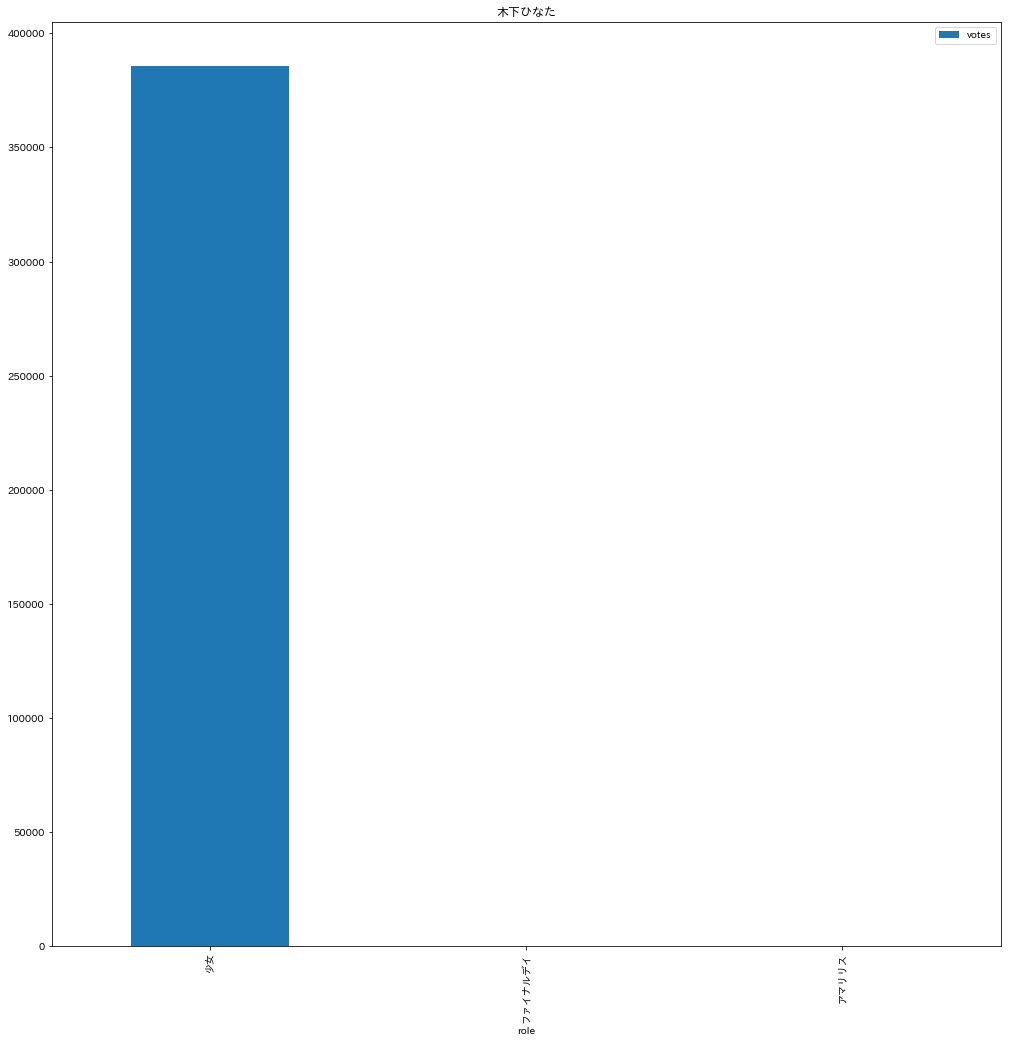

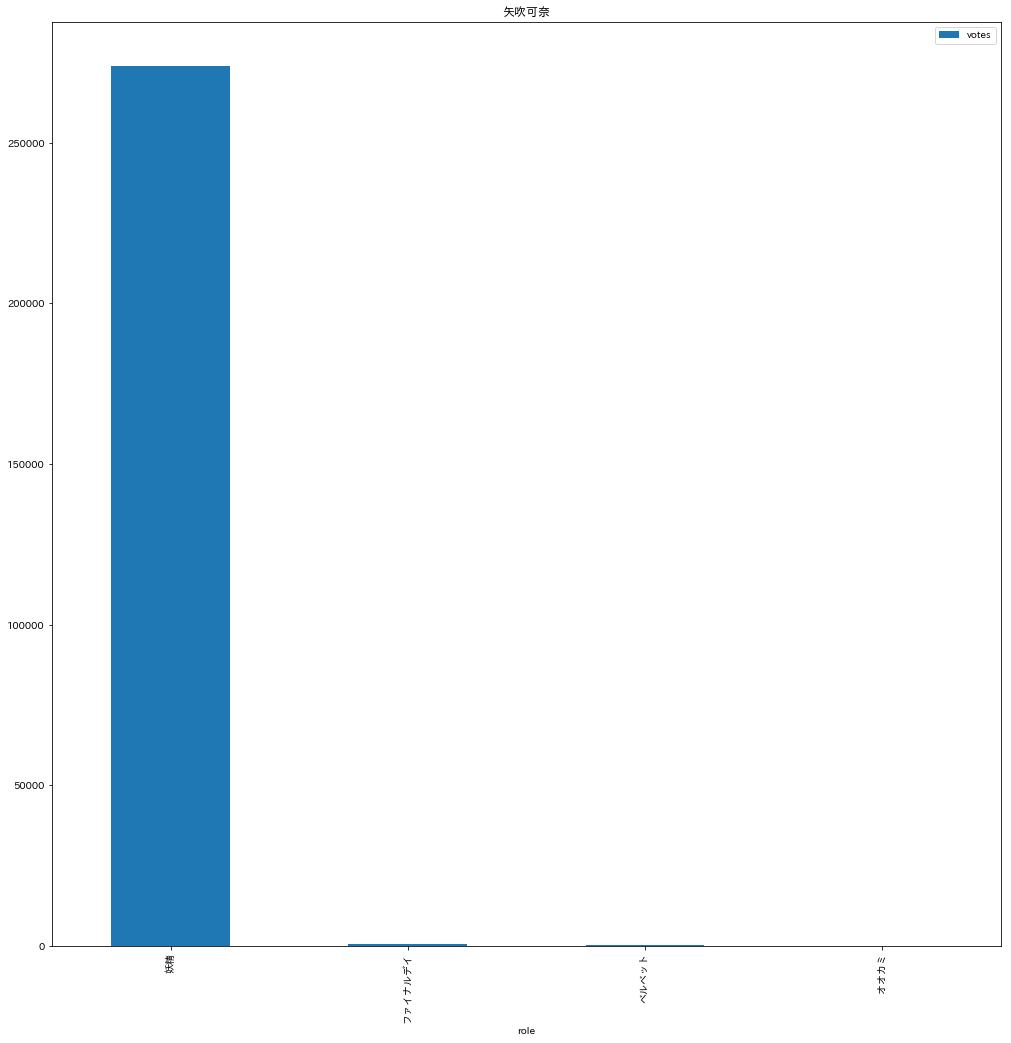

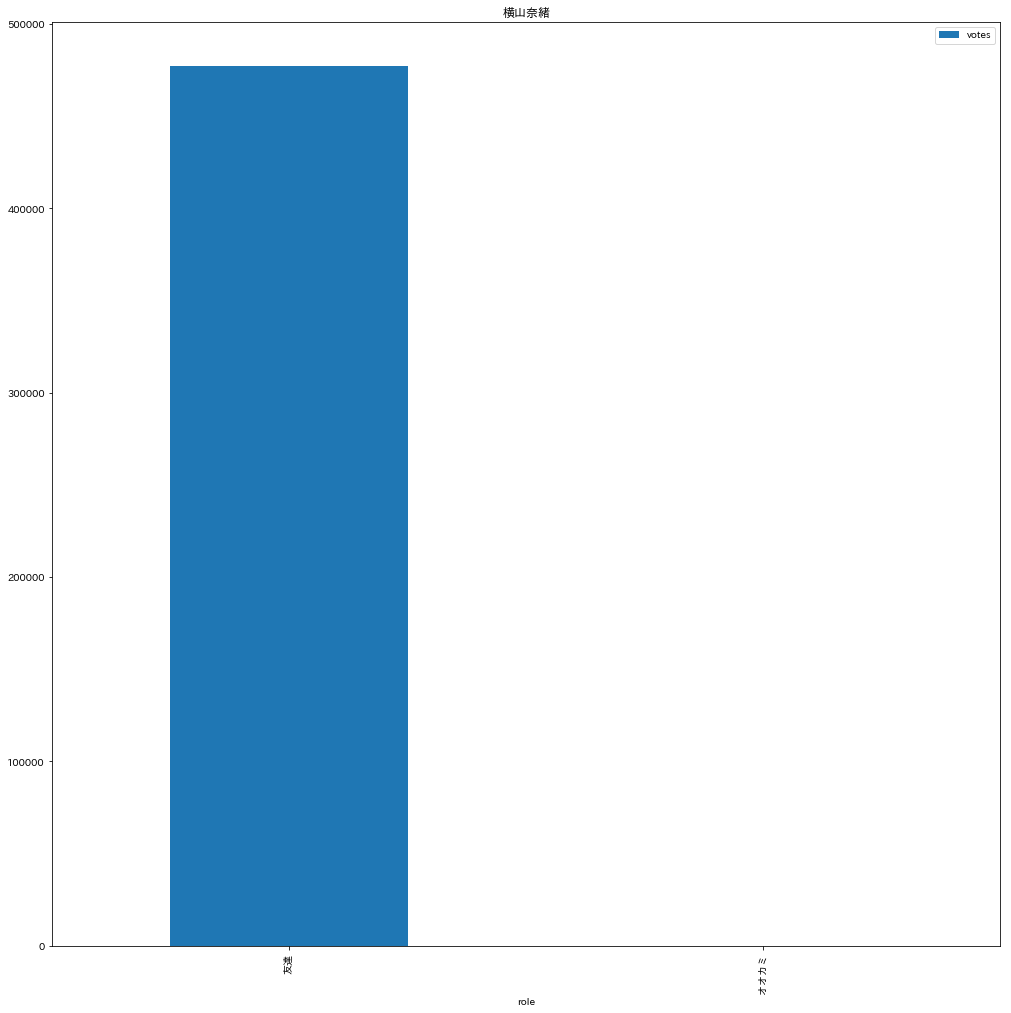

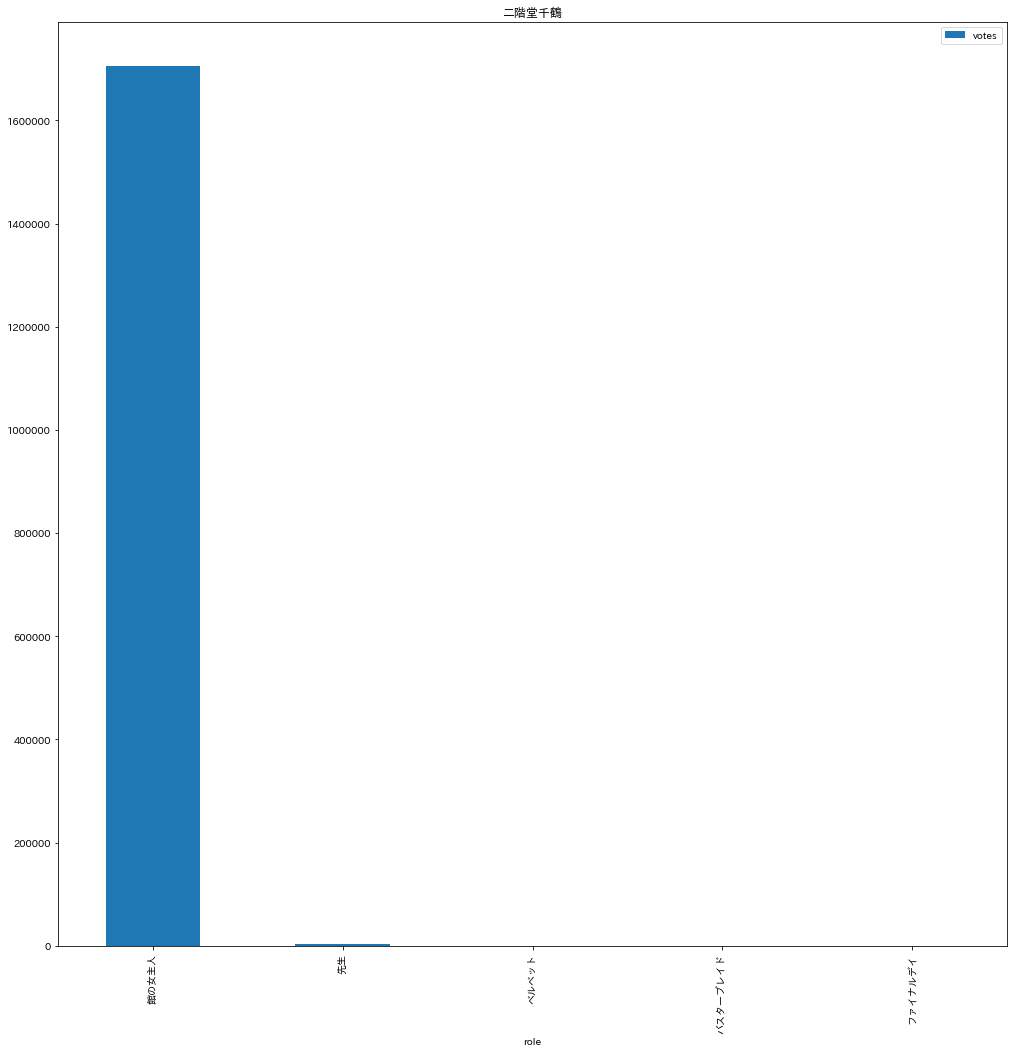

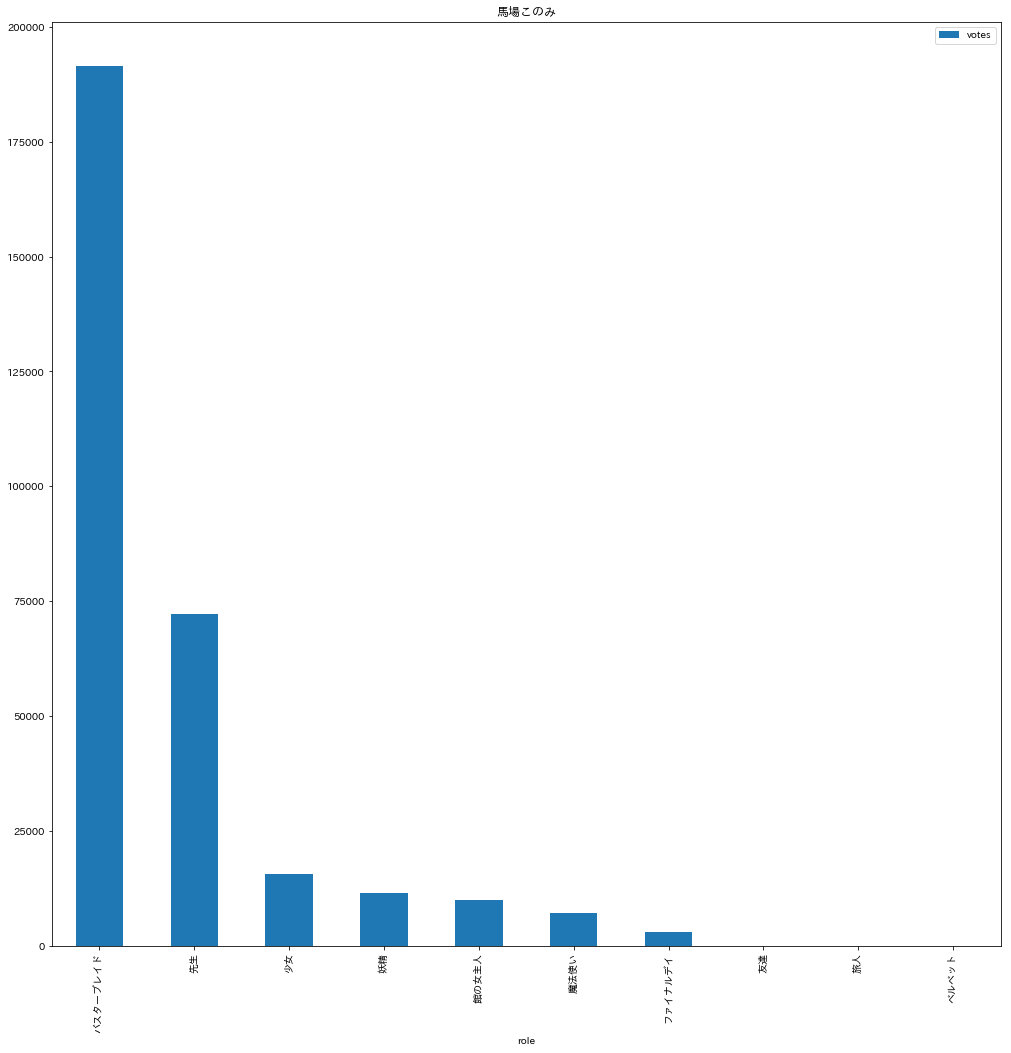

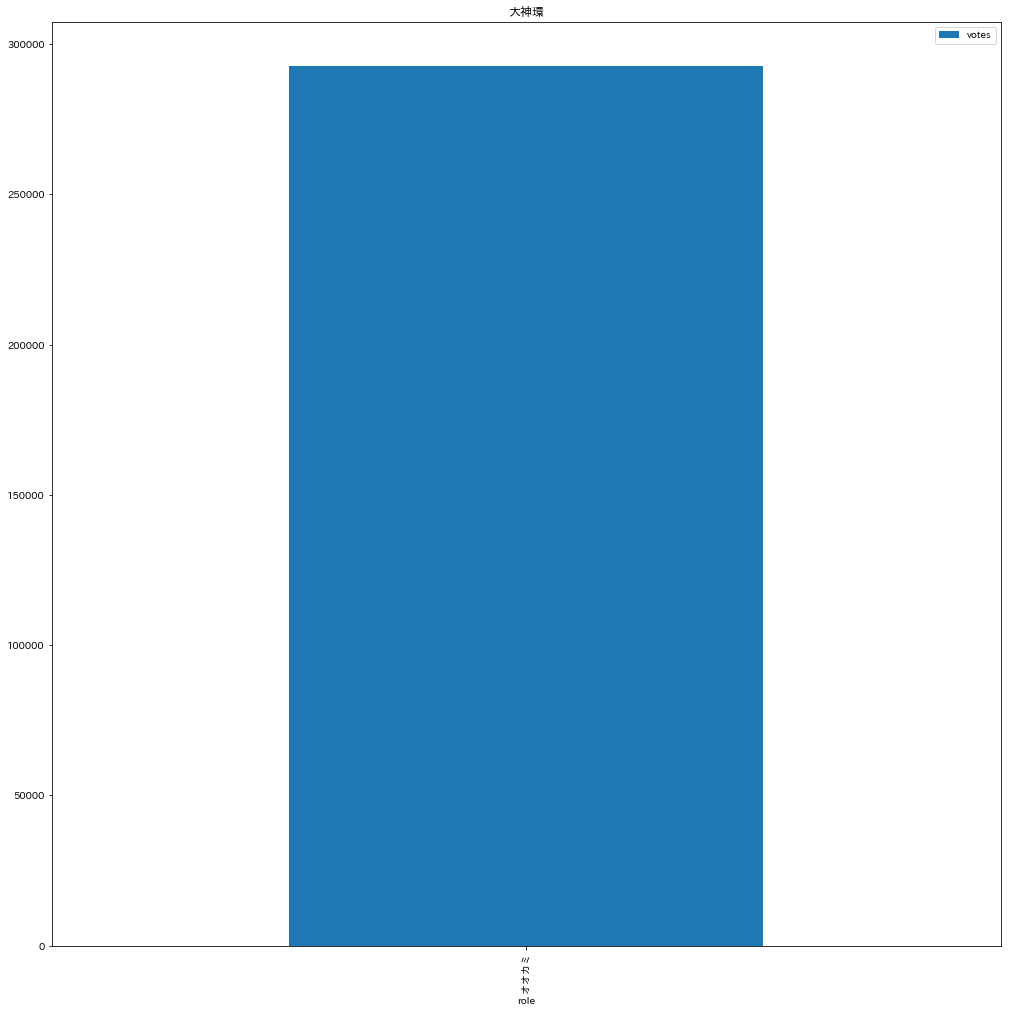

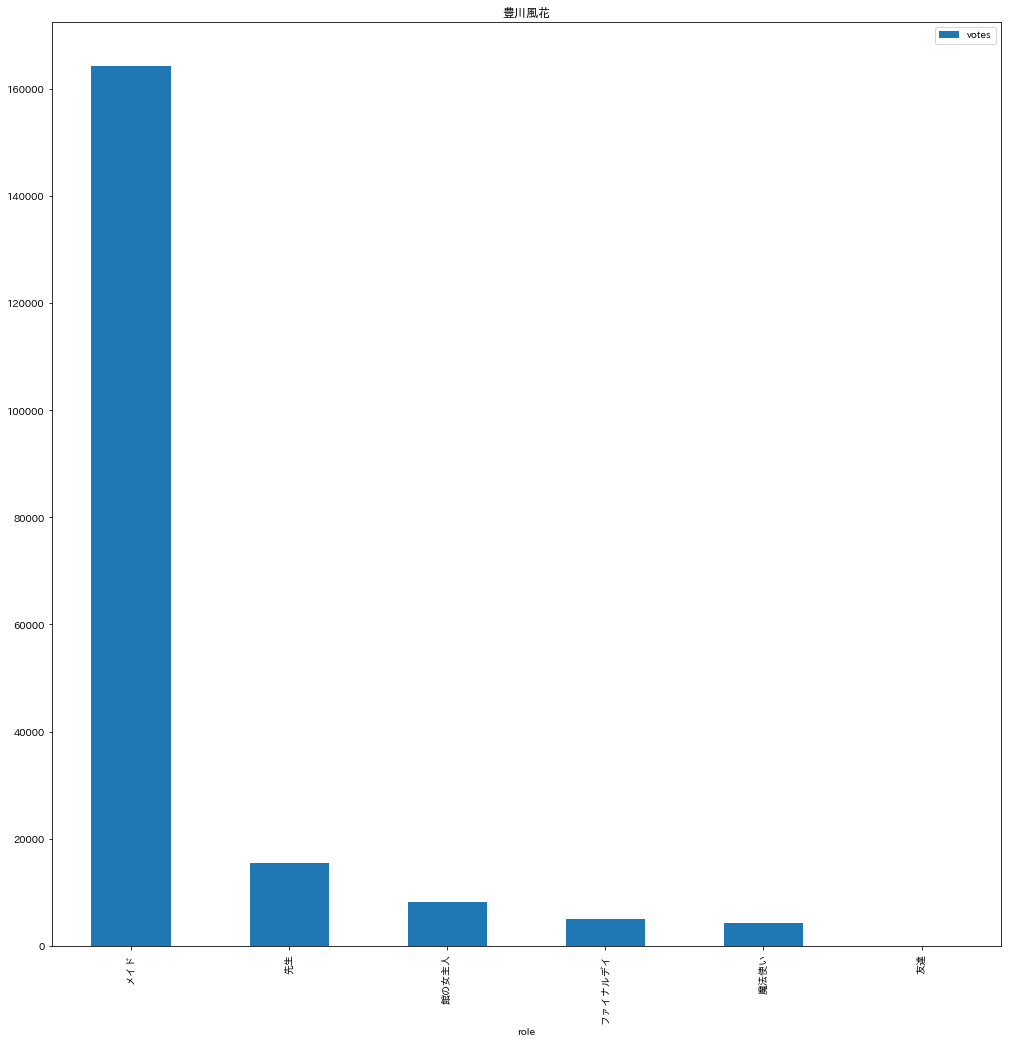

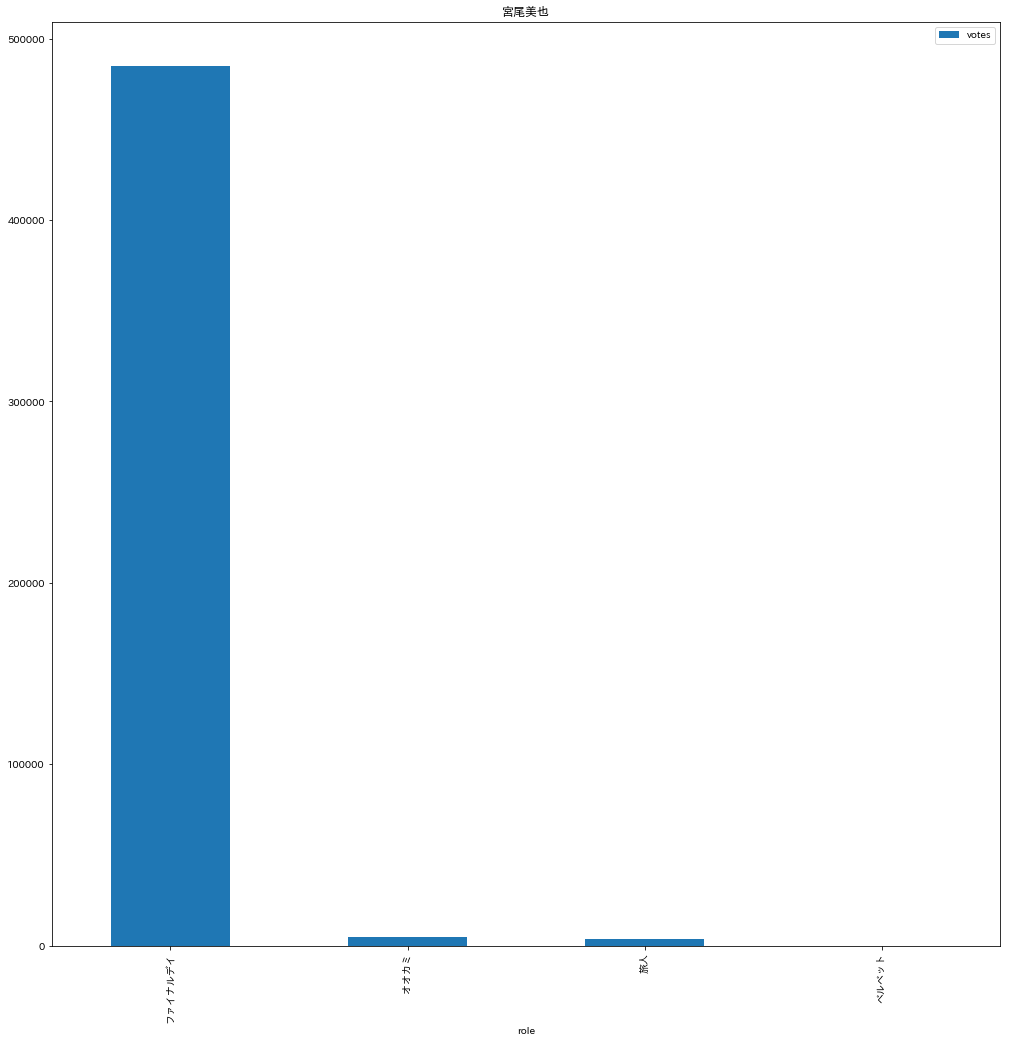

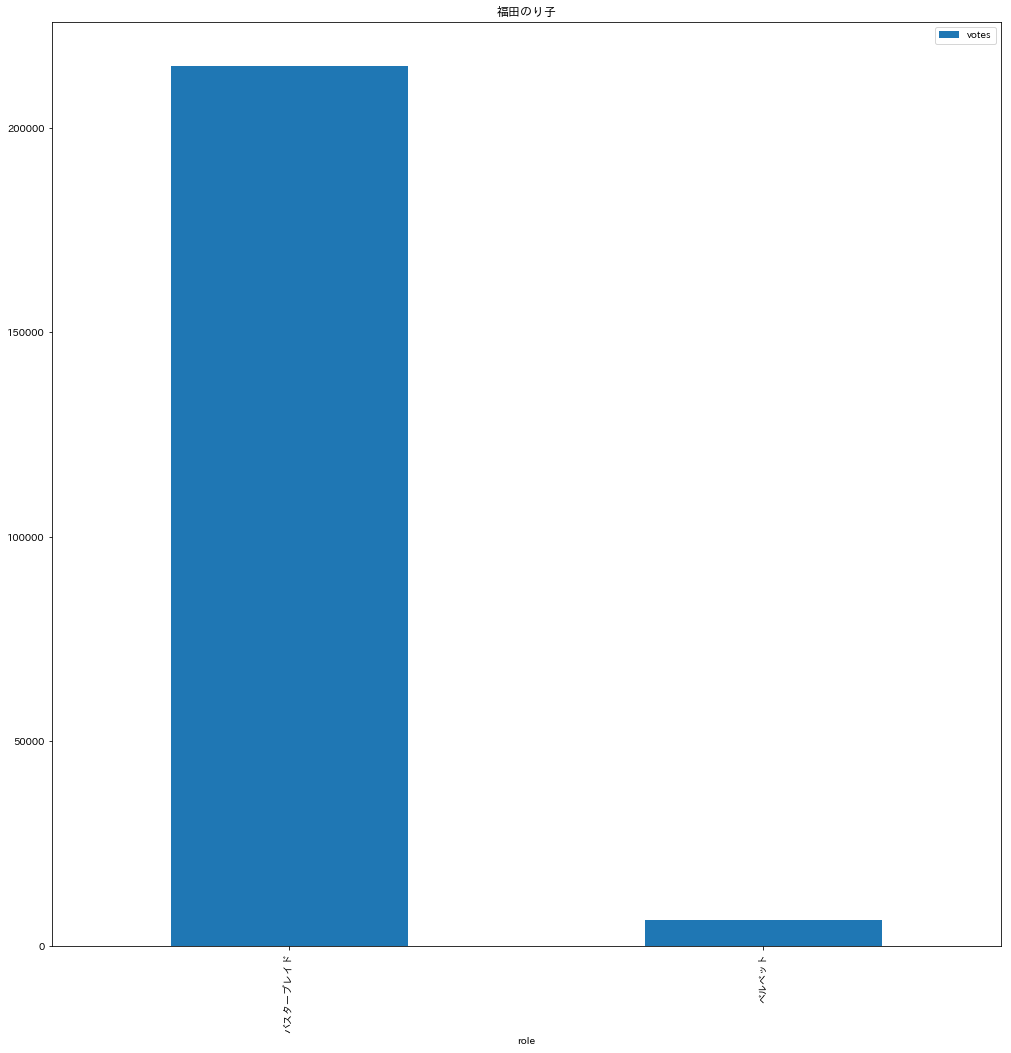

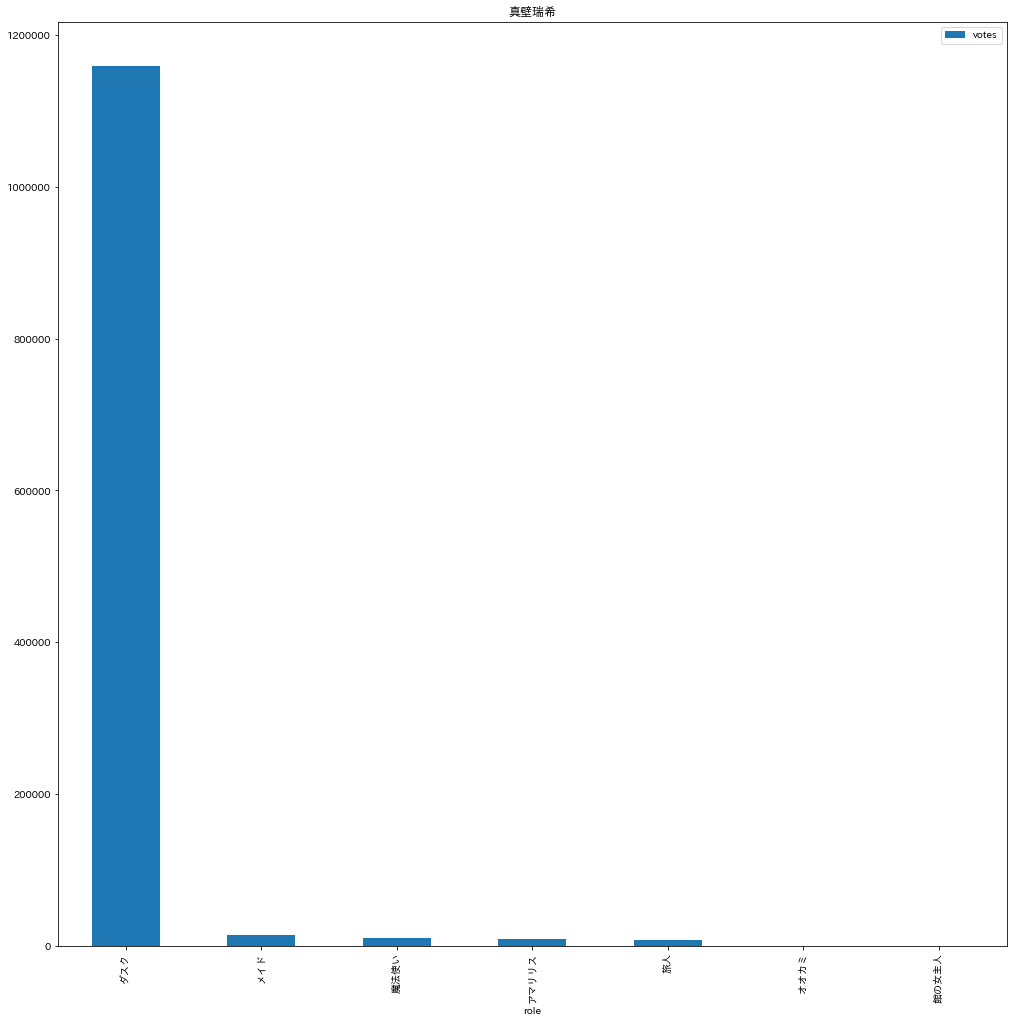

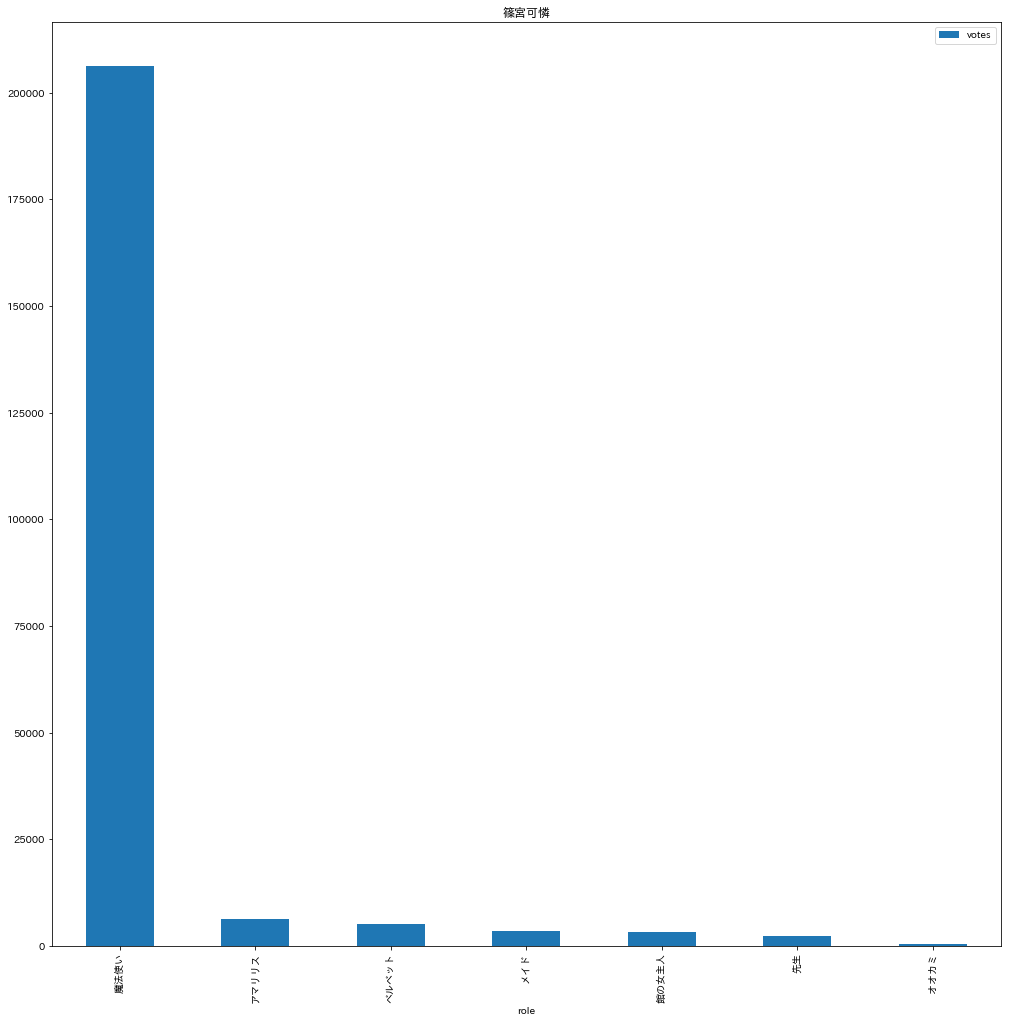

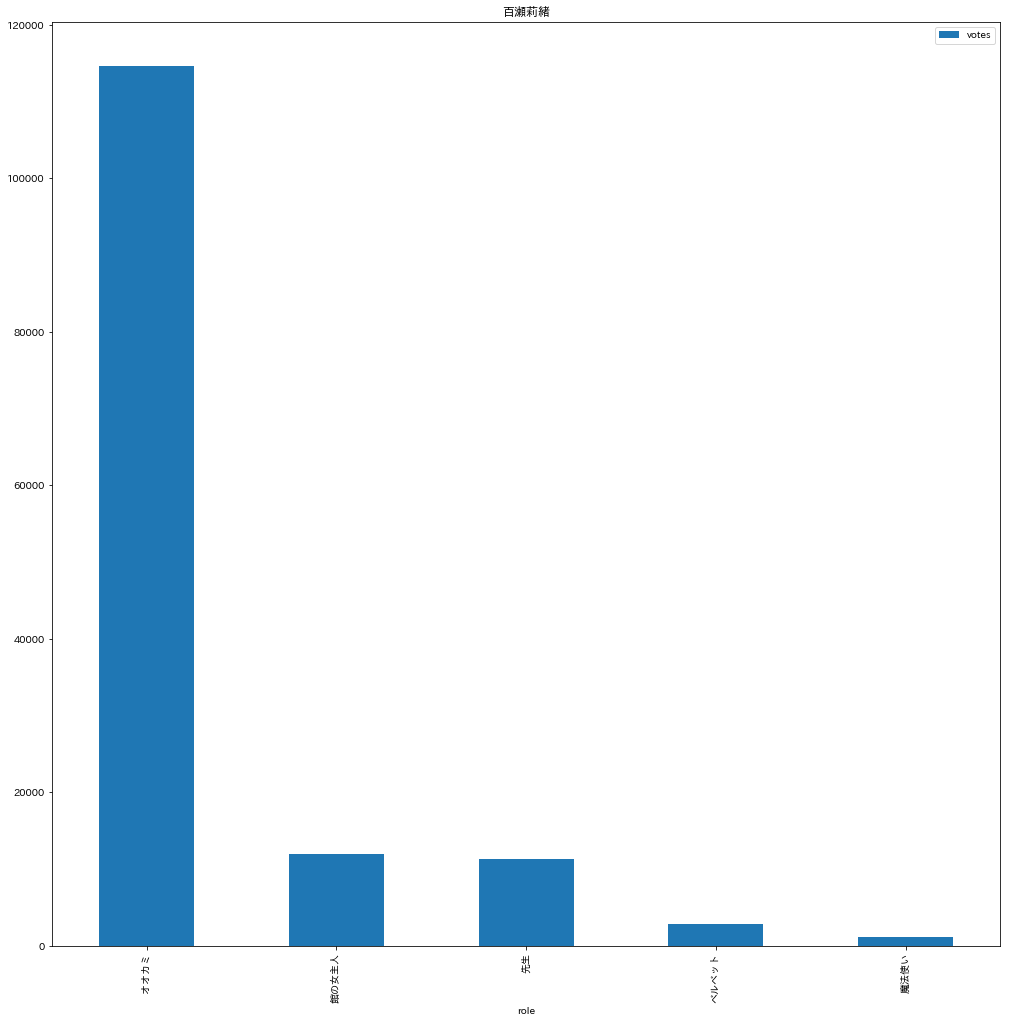

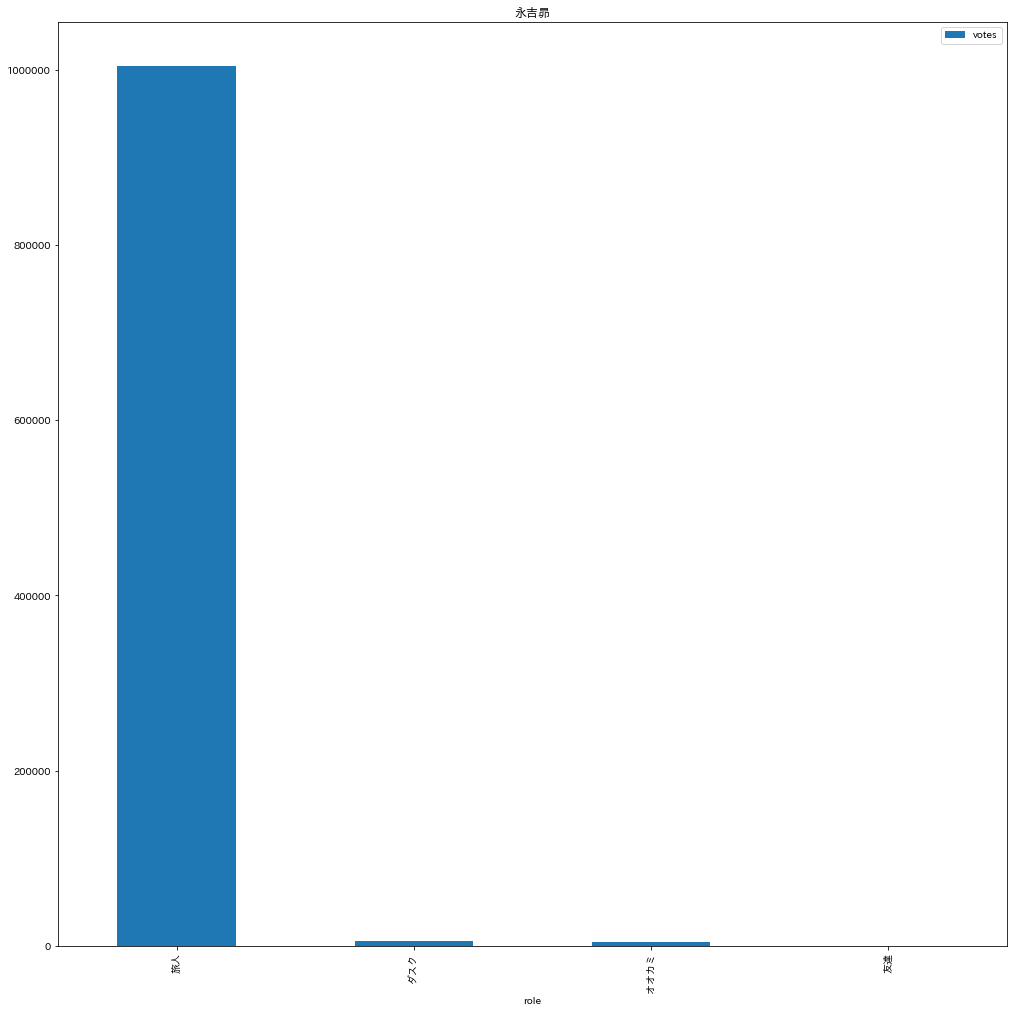

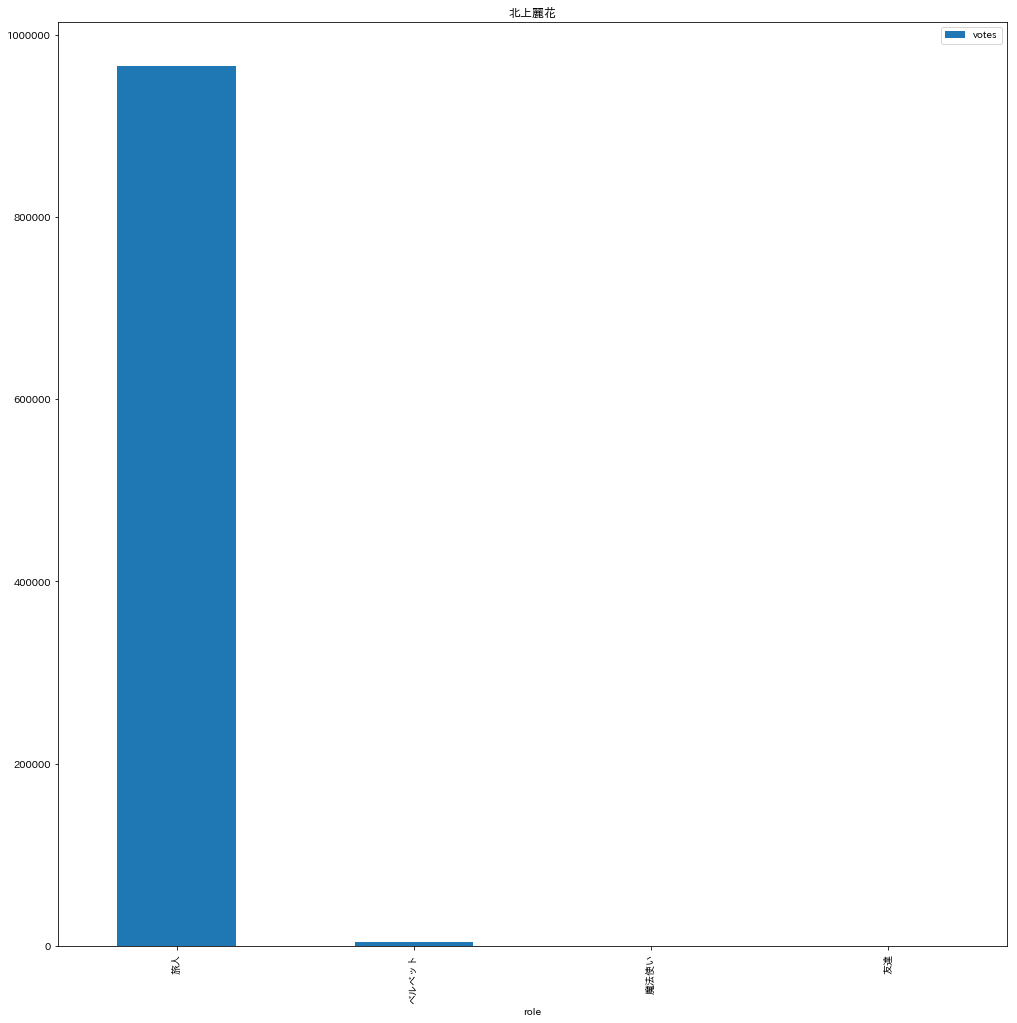

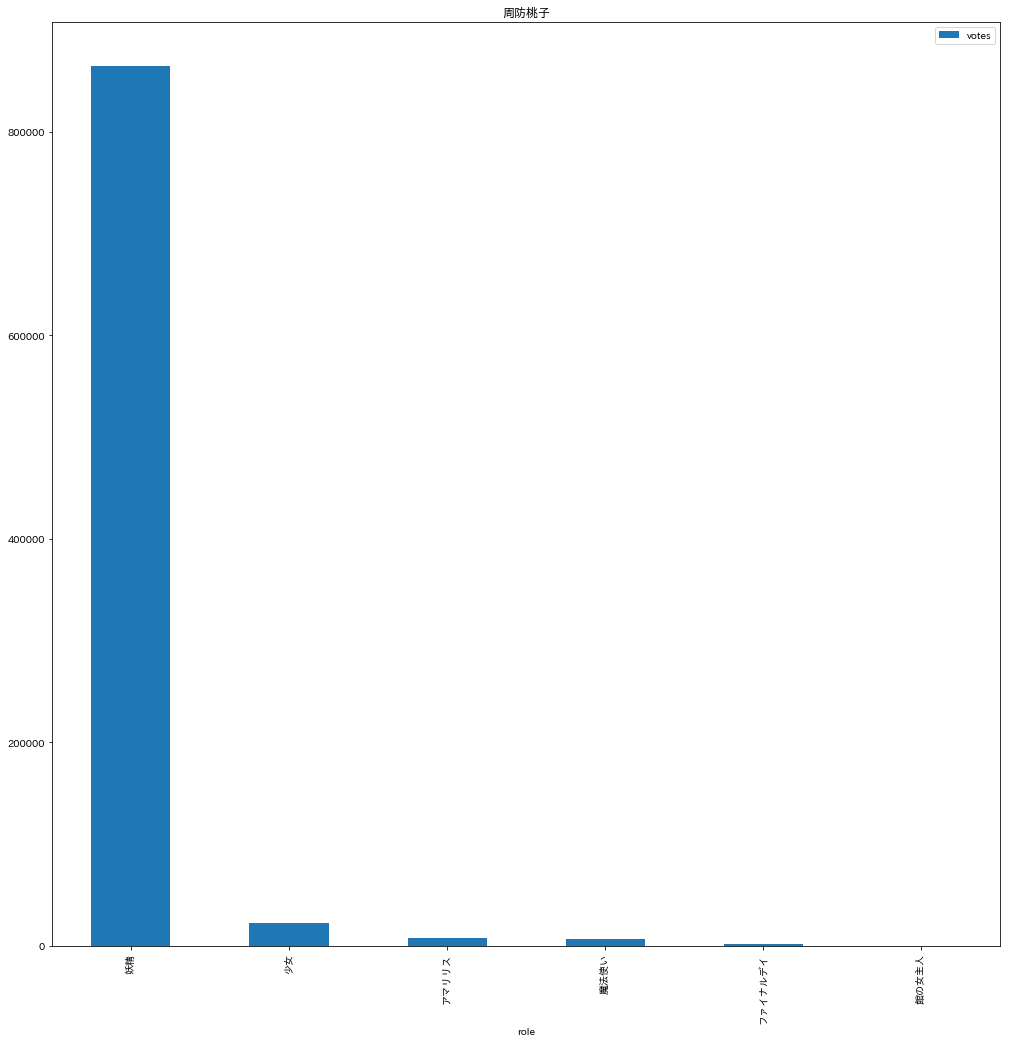

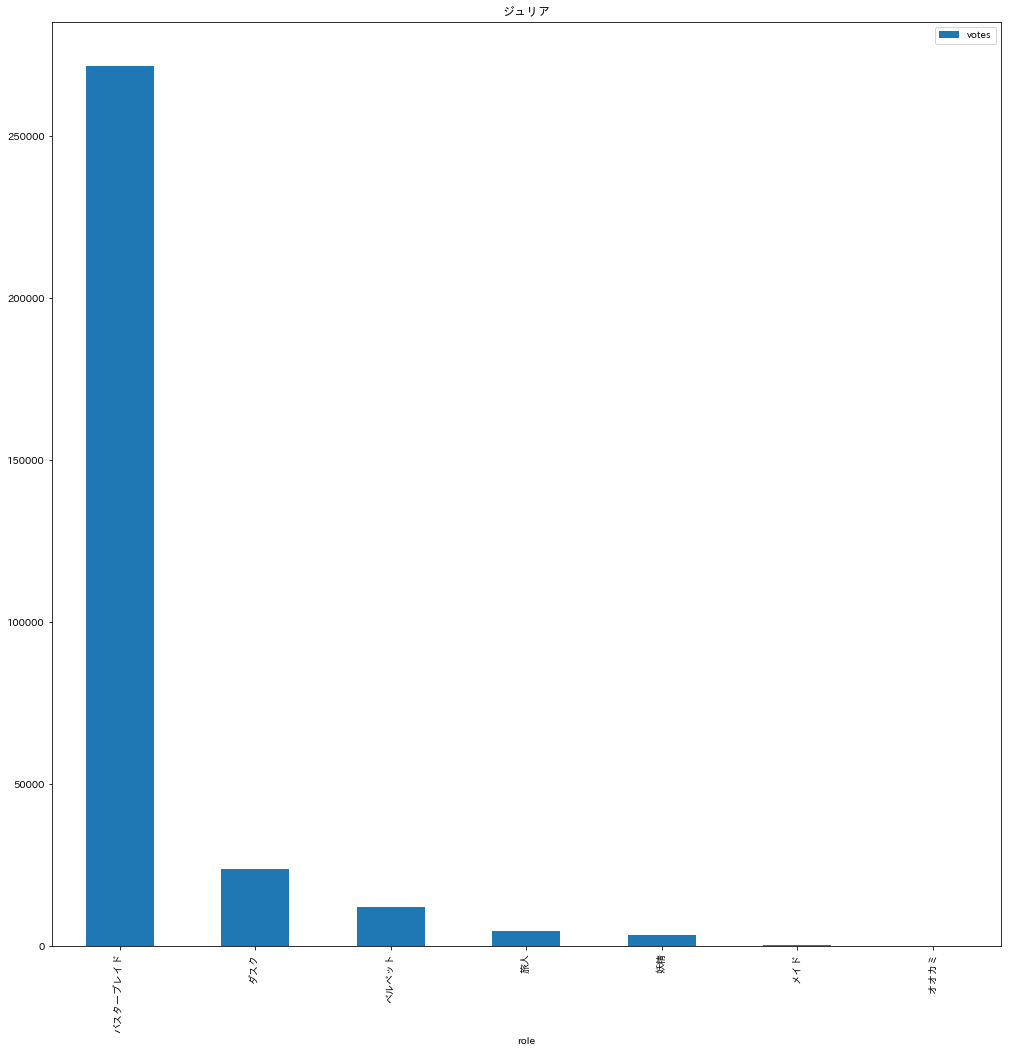

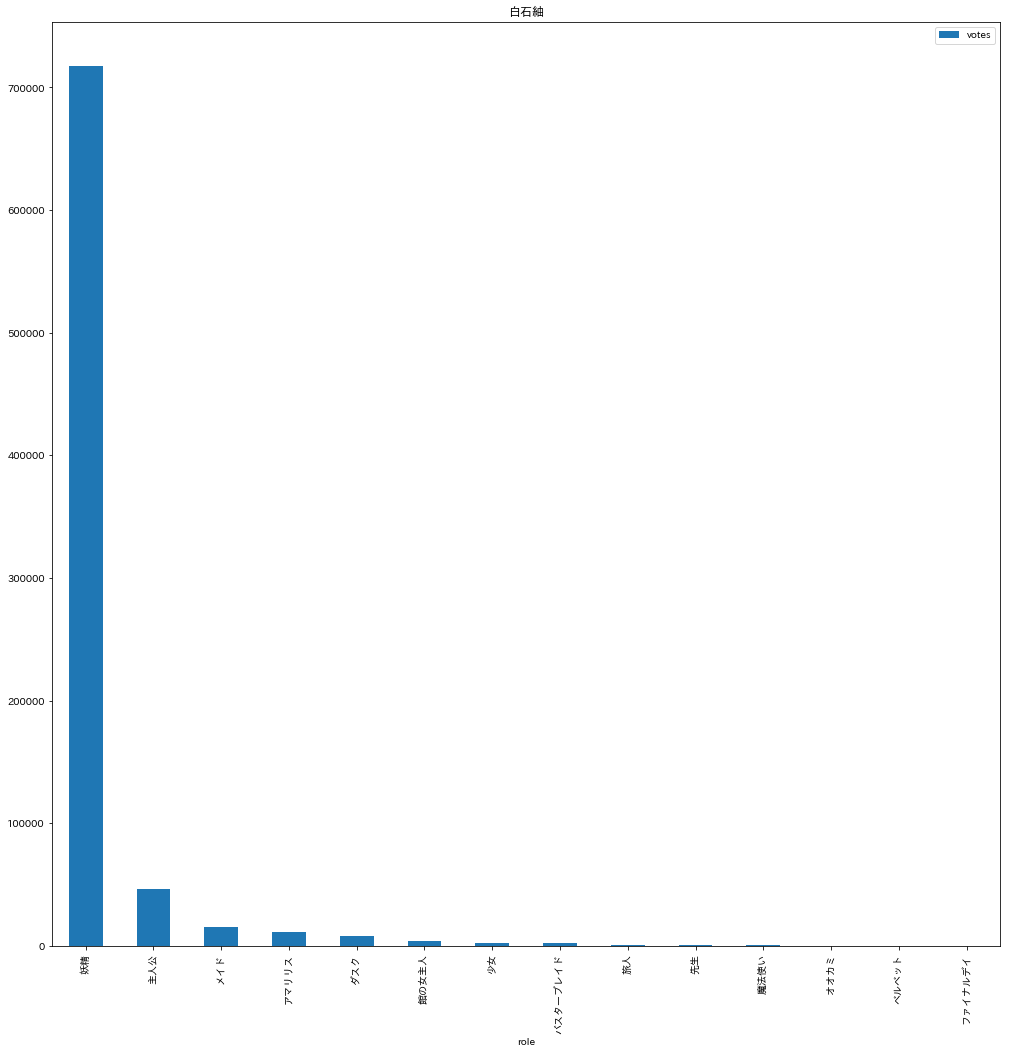

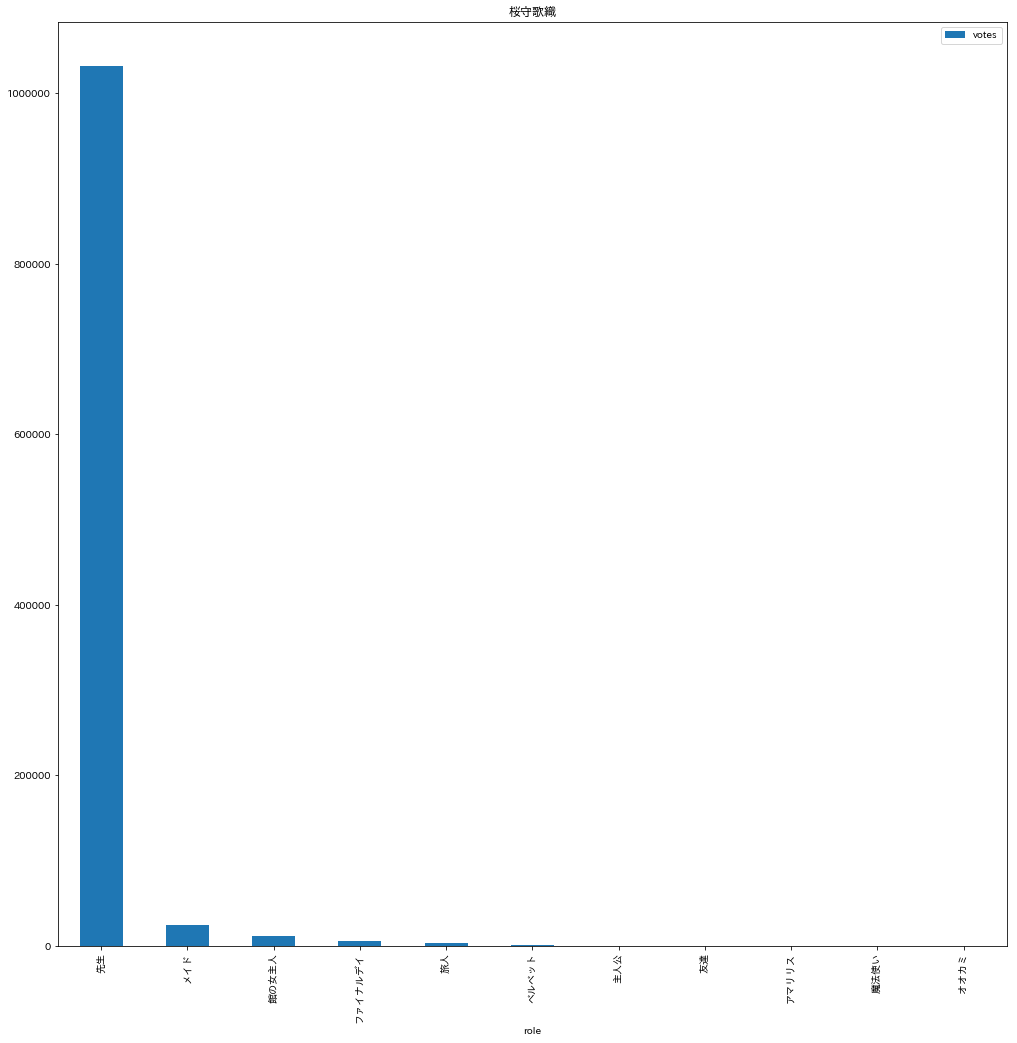

In [166]:

for plotdata  in df_finalvotes['idolid'].unique() :
    df_idol = df_finalvotes.loc[df_finalvotes['idolid'] == plotdata].set_index(['role'])
    df_idol = df_idol.rename(dict_roles)
    df_idol = df_idol.sort_values(by='votes',ascending=False)    
    df_idol_sum = df_idol['votes'].sum()
    df_idol['per'] = df_idol['votes'].map(lambda x : x*100/df_idol_sum)    
    df_idol.plot(kind='bar', y='votes',figsize=(17,17),title=dict_idols[plotdata])